In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import ipyparallel as ipp

from time import time
from datetime import datetime

import motif as mf

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from scipy.stats import spearmanr
from scipy.stats import pearsonr

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
### set parameters for the motif analysis

PROTEIN_NAME='T7 primase'
PROT_CONC=5 # free protein concentration at binding reation; PBM typically 0.1 and RNACompete typically 0.002
BOTH_STRANDS=False # wheter both strands are present for binding; True if double-stranded DNA or RNA is used as probes
TIME_DISS= 1800 # experimental time span after binding reaction during which dissociation of the protein from the probe was possible

STAGES=mf.stage(protein=PROTEIN_NAME)

In [3]:
### read data

dfprobes_raw=pd.read_csv('../chip_B_favor.csv', sep=';')
print('Columns of imported Data File: %s'%dfprobes_raw.columns)

Columns of imported Data File: Index(['0_nuc', '1_nuc', '2_nuc', '3_nuc', '4_nuc', '5_nuc', '6_nuc', '7_nuc',
       '8_nuc', '9_nuc', '10_nuc', '11_nuc', '12_nuc', '13_nuc', '14_nuc',
       '15_nuc', '16_nuc', '17_nuc', '18_nuc', '19_nuc', '20_nuc', '21_nuc',
       '22_nuc', '23_nuc', '24_nuc', '25_nuc', '26_nuc', '27_nuc', '28_nuc',
       '29_nuc', '30_nuc', '31_nuc', '32_nuc', '33_nuc', '34_nuc', '35_nuc',
       'prim_only_score', 'prim', 'poly', 'seq'],
      dtype='object')


I: DNA probes detected!


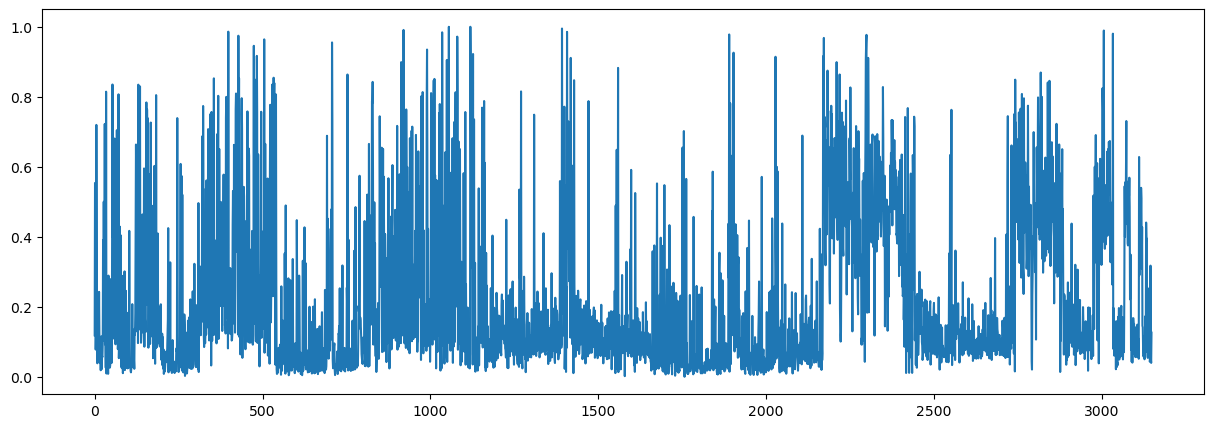

In [4]:
### select columns for probe sequence and signal

column_sequence='seq'
column_signal='prim_only_score'
#background_signal='mean_background_intensity'
background_signal=None                             #set to None if not needed

#basic preprocessing
dfprobes_raw[column_signal]=dfprobes_raw[column_signal].apply(lambda a: np.NaN if a==' ' else a)
dfprobes_raw[column_sequence]=dfprobes_raw[column_sequence].apply(lambda a: np.NaN if a=='nan' else a)
dfprobes_raw=dfprobes_raw.dropna()

#construct new dataframe with only necessary data
if type(background_signal)==type(None):
    dfprobes=pd.DataFrame({'seq':dfprobes_raw[column_sequence].astype(str),
                           'signal binding': dfprobes_raw[column_signal].astype(np.float32)}) #rebuild dataframe
else:
    dfprobes=pd.DataFrame({'seq':dfprobes_raw[column_sequence].astype(str),
                           'signal': dfprobes_raw[column_signal].astype(np.float32), 
                           'background':dfprobes_raw[background_signal].astype(np.float32)}) #rebuild dataframe
    dfprobes['signal binding']=dfprobes['signal']-dfprobes['background']
# display main properties of data set

dfprobes['signal binding']=dfprobes['signal binding']**2  # as raw data was squared

dfprobes['signal binding'].plot(figsize=(15,5))
dfprobes.describe()

### check type of nucleic acid

dfprobes['seq']=dfprobes['seq'].apply(lambda seq: seq.upper().replace(" ", ""))  #upper and remove blanks
dfprobes['RNA']=dfprobes['seq'].apply(lambda seq: all(char in 'ACGU' for char in seq))
dfprobes['DNA']=dfprobes['seq'].apply(lambda seq: all(char in 'ACGT' for char in seq))
non_RNA_counts=len(dfprobes[dfprobes['RNA']==False])
non_DNA_counts=len(dfprobes[dfprobes['DNA']==False])

if non_RNA_counts<non_DNA_counts:
    NUC_TYPE='RNA'; print('I: RNA probes detected!')
else: NUC_TYPE='DNA'; print('I: DNA probes detected!')
    
if NUC_TYPE=='RNA' and non_RNA_counts!=0:
    print('E: The probe sequences appear to be RNA, however there are some non-RNA nucleotides in the sequences.')
    print('E: Please check the following sequnces %s'%dfprobes[dfprobes['RNA']==False])

if NUC_TYPE=='DNA' and non_DNA_counts!=0:
    print('E: The probe sequences appear to be RNA, however there are some non-RNA nucleotides in the sequences.')
    print('E: Please check the following sequnces %s'%dfprobes[dfprobes['DNA']==False])

In [5]:
### option to add a constant sequence at the 3' end and 5' end
sequence_to_be_added_5='' 
sequence_to_be_added_3=''        # standard PBM arrays: CCTGTGTGAAATTGTTATCCGCTCT T7 array: GTCTTGA..
dfprobes['seq']=sequence_to_be_added_5.upper()+dfprobes['seq']+sequence_to_be_added_3.upper()
print(f"I: The nucleotide sequences {sequence_to_be_added_5.upper()} has been added to the 5' end all probe sequences.")
print(f"I: The nucleotide sequences {sequence_to_be_added_3.upper()} has been added to the 3' end all probe sequences.")

I: The nucleotide sequences  has been added to the 5' end all probe sequences.
I: The nucleotide sequences  has been added to the 3' end all probe sequences.


I: Probe sequences have the uniform length of 36 nucleotides
I: Total datasets contains 3149 sequences.
I: Visualisation of the base composition per position
I: If positions are invariant they can be removed before sequence analysis.


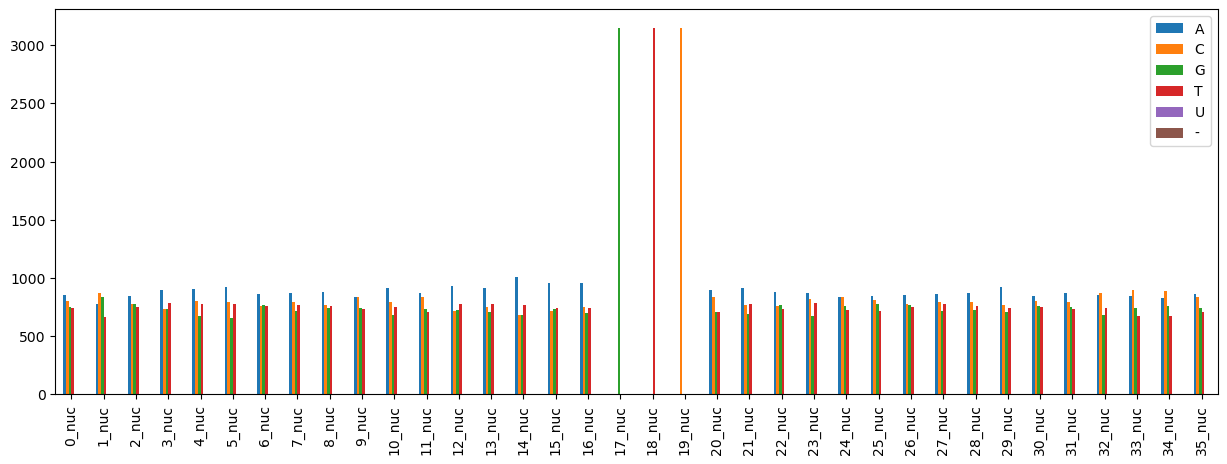

In [6]:
### egalize length
dfprobes['seq_length']=dfprobes['seq'].apply(len)    

if max(dfprobes['seq_length'])!=min(dfprobes['seq_length']):
    print('I: Probes length is not uniform, detected range: %i ..%i' %(min(dfprobes['seq_length']),max(dfprobes['seq_length'])))
    max_length=max(dfprobes['seq_length'])
    dfprobes['padded_sequence']=dfprobes['seq'].apply(lambda seq: seq+((max_length-len(seq))*'-'))
    print("I: Probe sequences have been padded at the 5' to the uniform length of %i nucleotides" %max_length)
else:
    print('I: Probe sequences have the uniform length of %i nucleotides' %(dfprobes['seq_length'].median()))
    dfprobes['padded_sequence']=dfprobes['seq']

print('I: Total datasets contains %i sequences.' % len(dfprobes))

# visualize composition of each position
df_nucleotides=mf.split_sequence_in_nucleotides(dfprobes['padded_sequence'])
dfcount=pd.DataFrame(index=['A', 'C', 'G', 'T', 'U', '-'])
for column in df_nucleotides:
    dfcount[column]=df_nucleotides[column].value_counts() 
dfcount=dfcount.fillna(0) #zeros for NaN
dfcount.transpose().plot(figsize=(15,5), kind='bar')
print('I: Visualisation of the base composition per position')
print('I: If positions are invariant they can be removed before sequence analysis.')

I: Visualisation of the base composition per position after slicing.


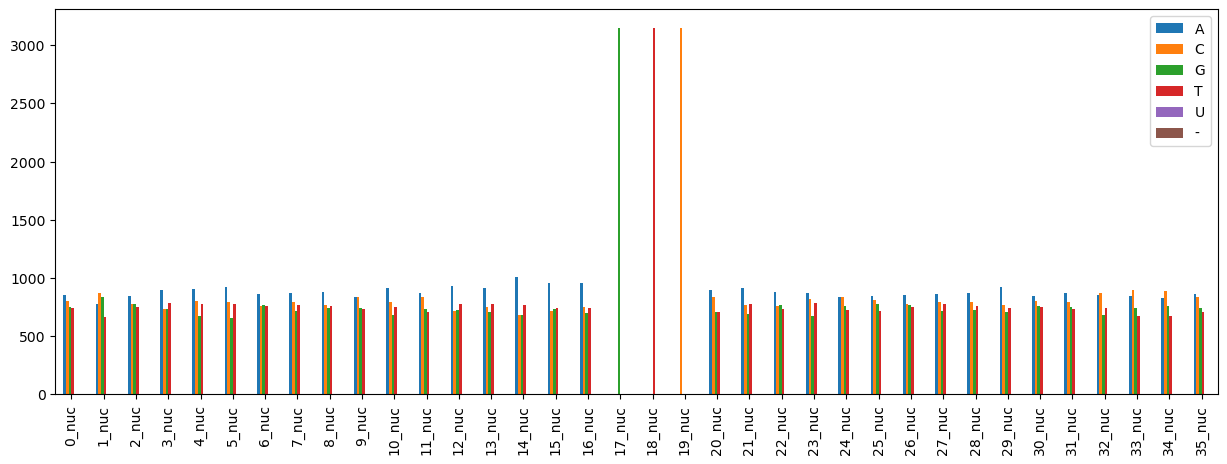

I: The whole dataset has been used to set the threshold for a positive probe.
T: The threshold is 0.663948
I: 196 probes of 3149 are above threshold.


In [7]:
# You may remove invariant continuos positions by adjusting the slicing. 
# It is recommended to leave a few invariant positions to allow for binding events
# between the variable and constant part of the probes.

dfprobes['padded_sequence']=dfprobes['padded_sequence'].apply(lambda s:s[:43]) ### <==== do the slicing here

# visualize composition of each position
print('I: Visualisation of the base composition per position after slicing.')
df_nucleotides=mf.split_sequence_in_nucleotides(dfprobes['padded_sequence'])
dfcount=pd.DataFrame(index=['A', 'C', 'G', 'T', 'U', '-'])
for column in df_nucleotides:
    dfcount[column]=df_nucleotides[column].value_counts() 
dfcount=dfcount.fillna(0) #zeros for NaN
dfcount.transpose().plot(figsize=(15,5), kind='bar')
plt.show()

### Preparation for later classification
mean=dfprobes['signal binding'].mean()
std=dfprobes['signal binding'].std()
THRESHOLD=mean+2*std   
dfprobes['positive probe']=dfprobes['signal binding'].apply(lambda s: True if s>THRESHOLD else False)

print('I: The whole dataset has been used to set the threshold for a positive probe.')
print('T: The threshold is %f' %THRESHOLD)
print(f"I: {len(dfprobes[dfprobes['positive probe']])} probes of {len(dfprobes)} are above threshold.")

I: The whole dataset has been split in training (80%) and test (20%) datasets and with the threshold indicated.


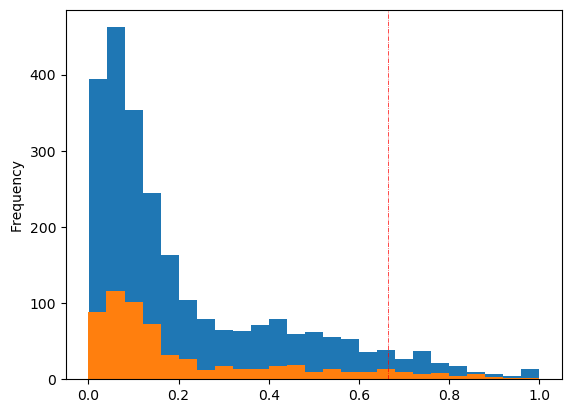

In [8]:
### Shuffle and prepare dataset for training and testing

# shuffle and split
dfprobes = shuffle(dfprobes)
dftrain, dftest = train_test_split(dfprobes, test_size=0.2)

print('I: The whole dataset has been split in training (80%) and test (20%) datasets and with the threshold indicated.')

# display histogramms of test and training set
dftrain['signal binding'].plot(kind='hist', bins=25).axvline(x=THRESHOLD, color='r', linestyle='-.', lw=0.5, label='threshold classification')
dftest['signal binding'].plot(kind='hist', bins=25)
plt.show()

# complete data
X=mf.hotencode_sequence(dfprobes['padded_sequence'], nuc_type=NUC_TYPE)
y=np.array(dfprobes['signal binding'])

# training set
X_train=mf.hotencode_sequence(dftrain['padded_sequence'], nuc_type=NUC_TYPE)
y_train=np.array(dftrain['signal binding'])

# test set
X_test=mf.hotencode_sequence(dftest['padded_sequence'], nuc_type=NUC_TYPE)
y_test=np.array(dftest['signal binding'])

I: Optimization took 0.01 hours.
I: energy matrix and logos:



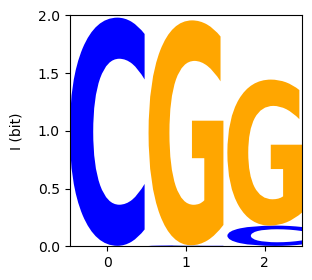

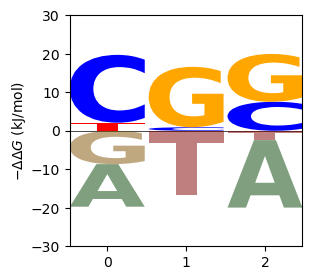


        A      C      G      T
0  11057 -17627   8663  -2093
1     34   -922 -15693  16582
2  17522  -7533 -12418   2429

I: summed absolute energies of each position:
0    39442
1    33232
2    39903
dtype: int64

I: averaged summed energy over all positions: 37526
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -1315 +/- 16960
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


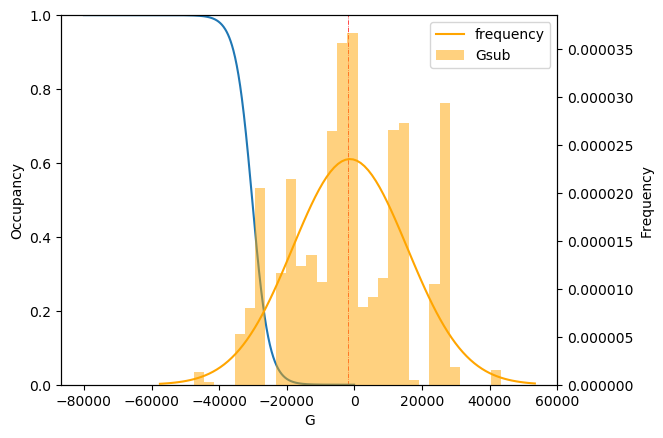

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.02189 .. 4.21834 (ratio: 192.7)
I: number of probes: 100
I: Pearson Correlation  r: 0.6590
I: mean absolute error: 0.1136


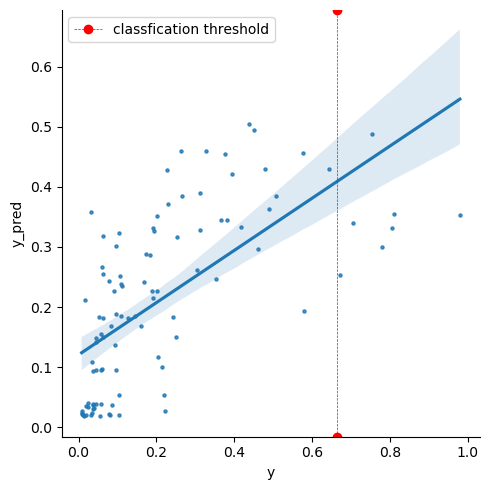

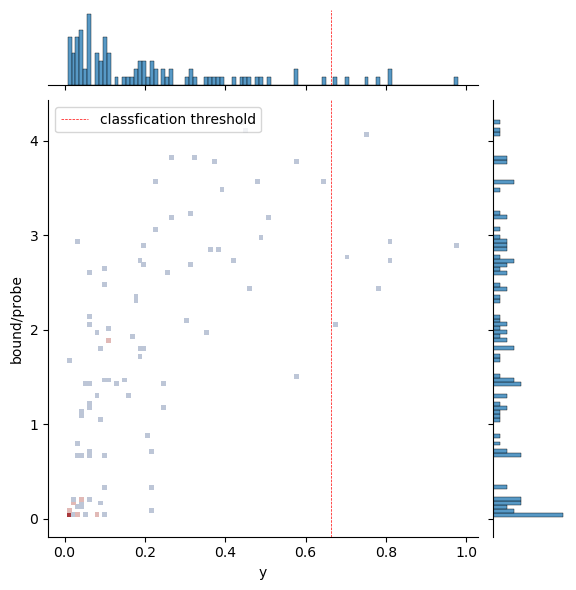

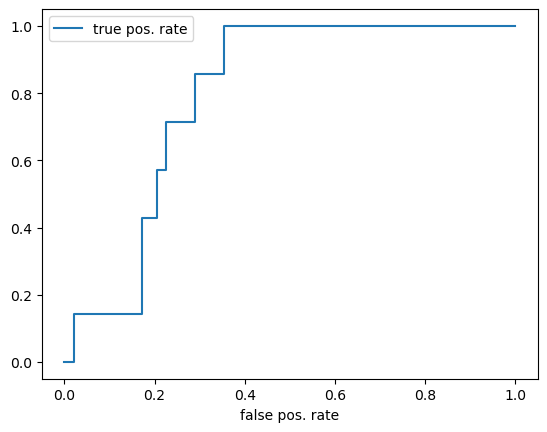

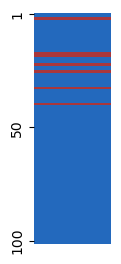

I: Classification performance AUROC: 0.7942


,stage,protein,# probes,motif length,r,AUROC,G0,G0 fitted,ratio,max binding,min binding,energies,model,logo
0,quick,T7 primase,100,3,0.659047,0.794163,-1785.711179,False,192.71984,4.218337,0.021888,"11057,..",suppressed,

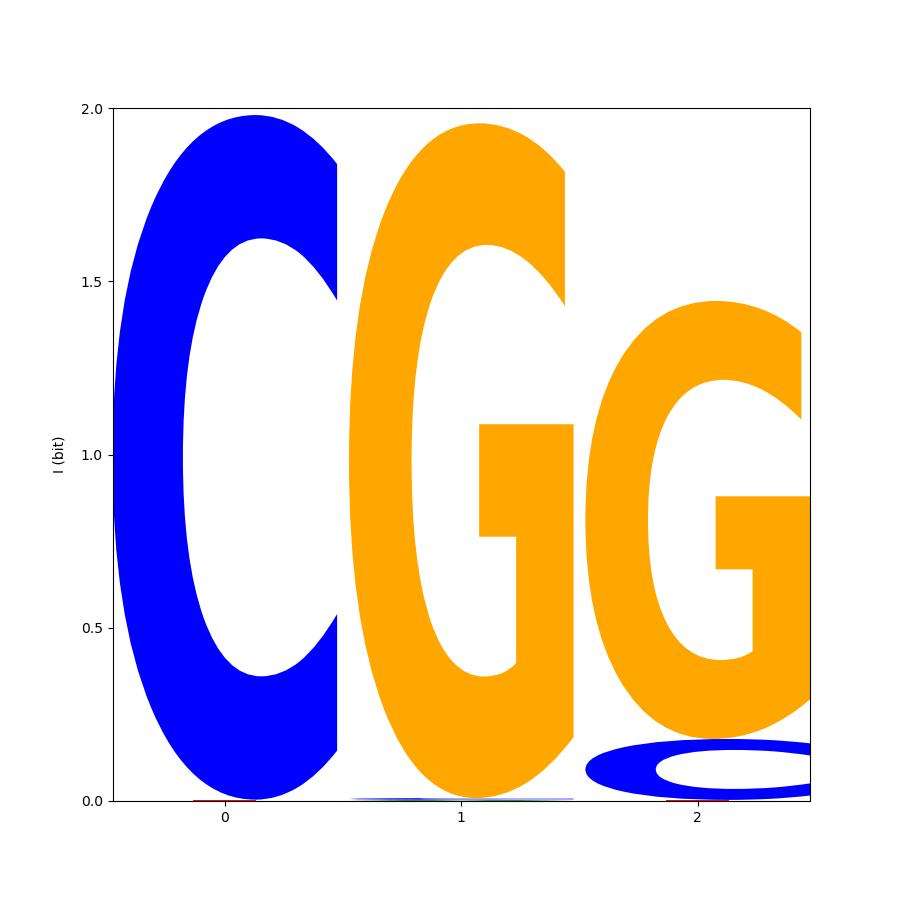

In [9]:
### perform a single round of motif fitting on subset of training set to check data integrity


#fit regression model
quick_model=mf.findmotif(motif_length=3, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS)

start = time()
quick_model.fit(X_train[:100],y_train[:100])
print("I: Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
quick_model.analyse_motif(X_train[:100],y_train[:100], THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('quick', quick_model)
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
I: GridSearchCV took 1.50 hours for 6 candidate parameter settings.
I: number of samples: 2519
I: Plot of r2 vs motif length and vs root(motif length)


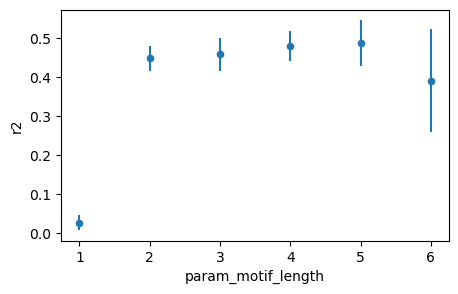

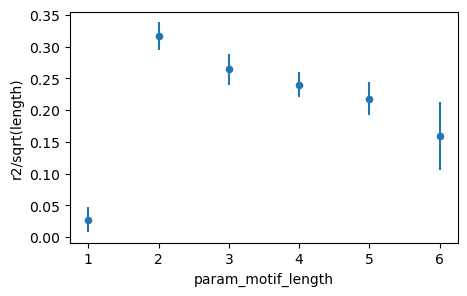

I: The maximum (2) is suggested as CORE_MOTIF_LENGTH
I: motif obtained with the best estimator from gridCV search
I: energy matrix and logos:



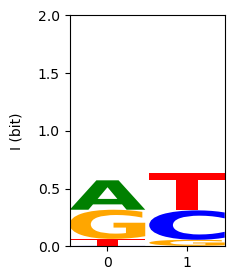

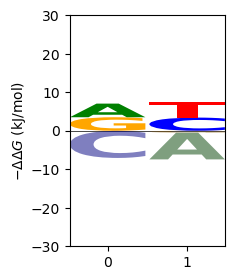


       A     C     G     T
0 -3539  7036 -3517    20
1  6947 -3425   484 -4006

I: summed absolute energies of each position:
0    14113
1    14863
dtype: int64

I: averaged summed energy over all positions: 14488
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -15652 +/- 5521
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


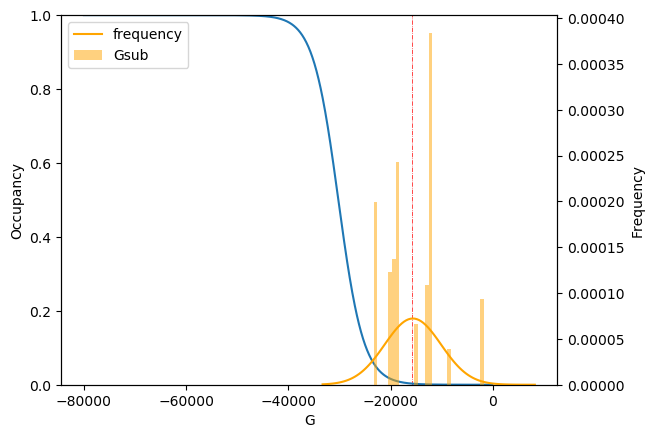

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.22876 .. 0.99939 (ratio: 4.4)
I: number of probes: 2519
I: Pearson Correlation  r: 0.6735
I: mean absolute error: 0.1124


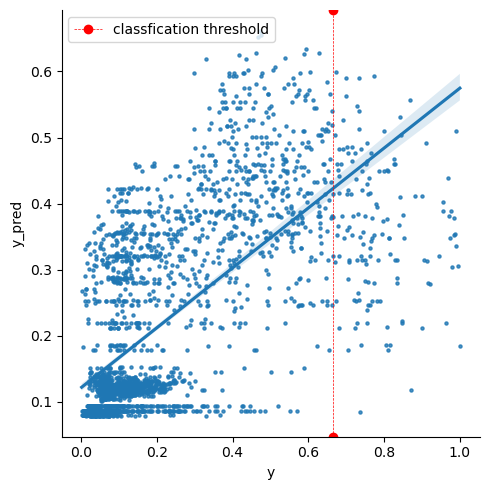

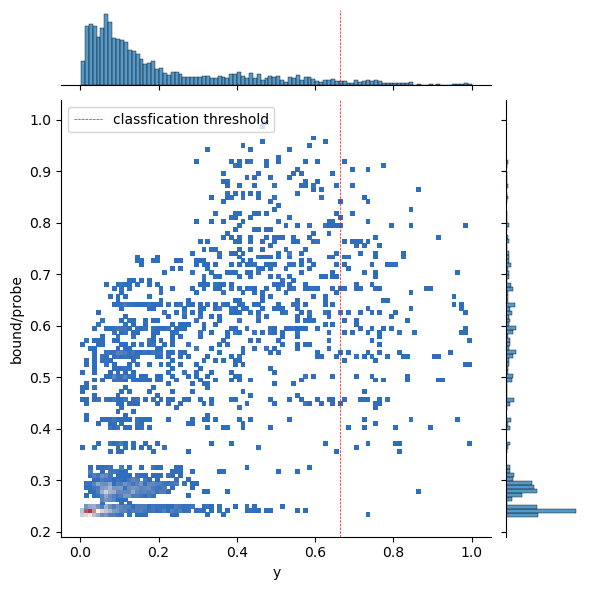

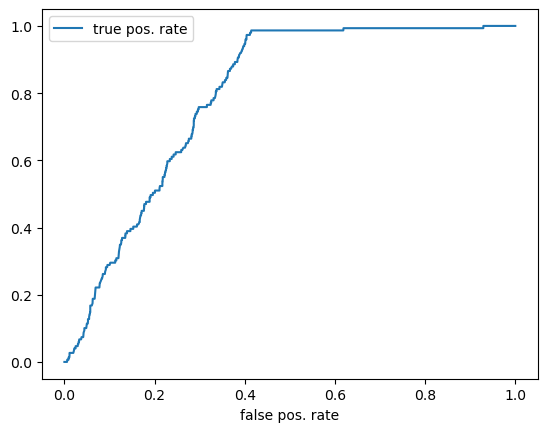

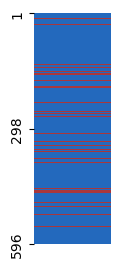

I: Classification performance AUROC: 0.7927


,stage,protein,# probes,motif length,r,AUROC,G0,G0 fitted,ratio,max binding,min binding,energies,model,logo
0,quick,T7 primase,100,3,0.659047,0.794163,-1785.711179,False,192.719840,4.218337,0.021888,"11057,..",suppressed,
1,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,

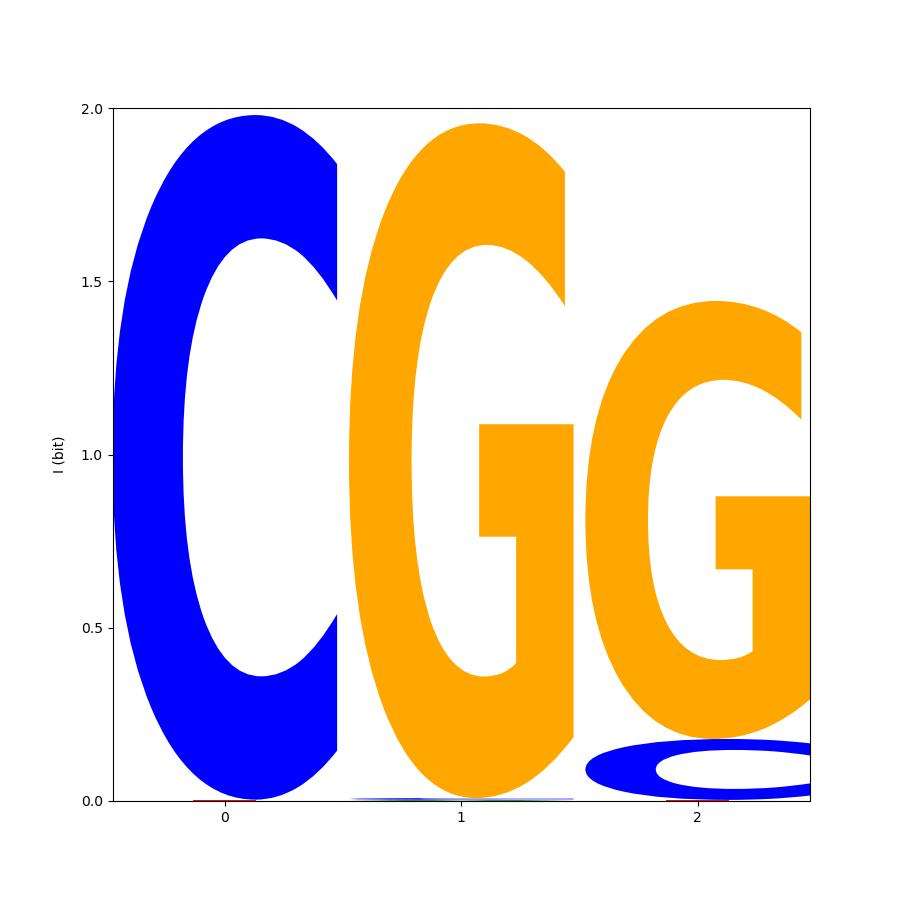
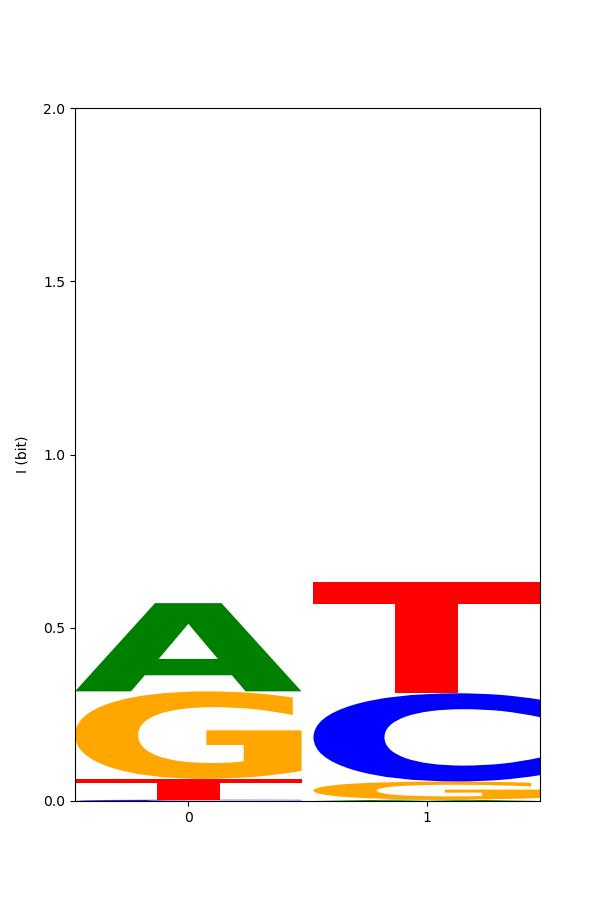

In [10]:
#### Perfrom GridCV Search for exploration of the motif length and other model parameters 
# primary goal: identify the minimum motif length which gives a good r-value

# optional: allow also for global optimization to verify whether the local optimization is good enough
# optional: vary G0 to find a good regression model
# optional: fitG0=True. This option adjust G0, so that maximal binding is around 1 (prevents saturation of probes by multiple binding events)


model_grid=mf.findmotif(protein_conc=PROT_CONC, both_strands=BOTH_STRANDS, fit_G0=True)

# prepare grid search over parameters
param_grid = {"motif_length": [1,2,3,4,5,6],
              "weight_information":[0],
              "weight_ratio": [0]}     # choose sensible range for length of motif and other parameters

# define custom refit function
def custom_refit(cv_results):
    """returns index of max r2/sqrt(motif_length)"""
    df_grid=pd.DataFrame(cv_results)
    index=(df_grid['mean_test_score']/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))).idxmax()
    return index

# run grid search and refit according to custom refit
grid_search = GridSearchCV(model_grid, param_grid=param_grid, verbose=2, cv=5, refit=custom_refit, n_jobs=-1)

start = time()
grid_search.fit(X_train, y_train)
df_grid=pd.DataFrame(grid_search.cv_results_)

print("I: GridSearchCV took %.2f hours for %d candidate parameter settings."
    % ((time() - start)/3600, len(grid_search.cv_results_["params"])))
print('I: number of samples: %i' %len(X_train))

df_grid=pd.DataFrame(grid_search.cv_results_)
print('I: Plot of r2 vs motif length and vs root(motif length)')
df_grid.rename(columns={'mean_test_score':'r2'}, inplace=True)
df_grid.plot(kind='scatter', x='param_motif_length', y='r2', yerr='std_test_score', figsize=(5,3)).set_xticks(param_grid["motif_length"])
df_grid['r2/sqrt(length)']=df_grid['r2']/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))
df_grid['std/sqrt(length)']=df_grid['std_test_score']/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))
df_grid.plot(kind='scatter', x='param_motif_length', y='r2/sqrt(length)',yerr='std/sqrt(length)', figsize=(5,3)).set_xticks(param_grid["motif_length"])
plt.show()

best_index=df_grid['r2/sqrt(length)'].idxmax()
CORE_MOTIF_LENGTH=df_grid.loc[best_index, 'param_motif_length']
print(f'I: The maximum ({CORE_MOTIF_LENGTH}) is suggested as CORE_MOTIF_LENGTH')

print('I: motif obtained with the best estimator from gridCV search')
# print & display results from best estimator
model_grid=grid_search.best_estimator_
model_grid.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('best grid', model_grid)
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)


I: energy matrix and logos:



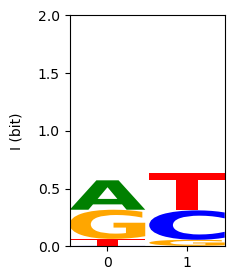

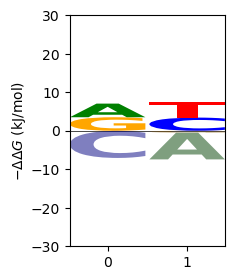


       A     C     G     T
0 -3539  7036 -3517    20
1  6947 -3425   484 -4006

I: summed absolute energies of each position:
0    14113
1    14863
dtype: int64

I: averaged summed energy over all positions: 14488
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -15652 +/- 5521
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


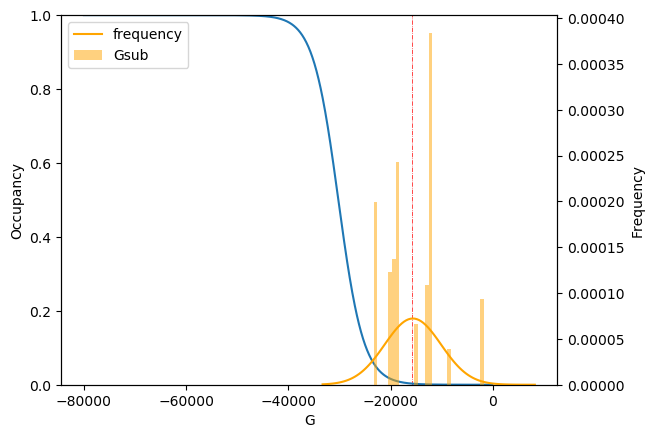

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.22876 .. 0.99939 (ratio: 4.4)
I: number of probes: 2519
I: Pearson Correlation  r: 0.6735
I: mean absolute error: 0.1124


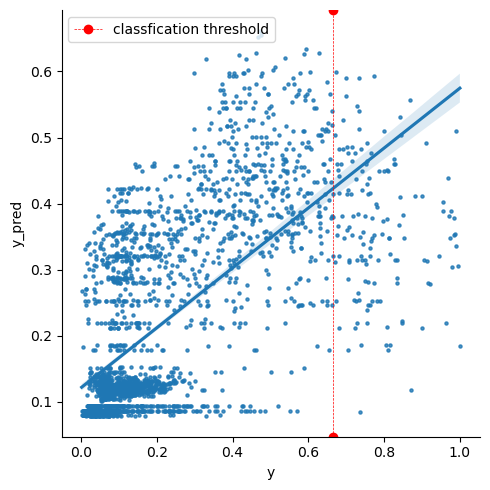

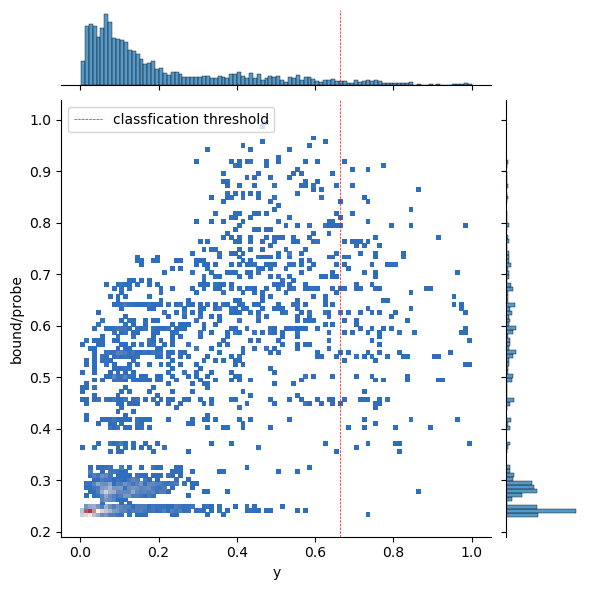

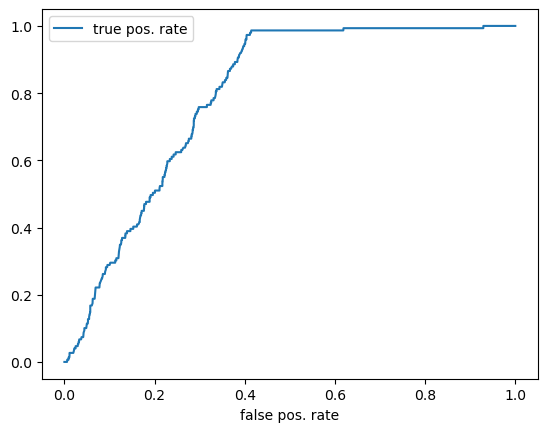

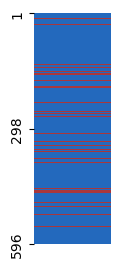

I: Classification performance AUROC: 0.7927


,stage,protein,# probes,motif length,r,AUROC,G0,G0 fitted,ratio,max binding,min binding,energies,model,logo
0,quick,T7 primase,100,3,0.659047,0.794163,-1785.711179,False,192.719840,4.218337,0.021888,"11057,..",suppressed,
1,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,
2,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,

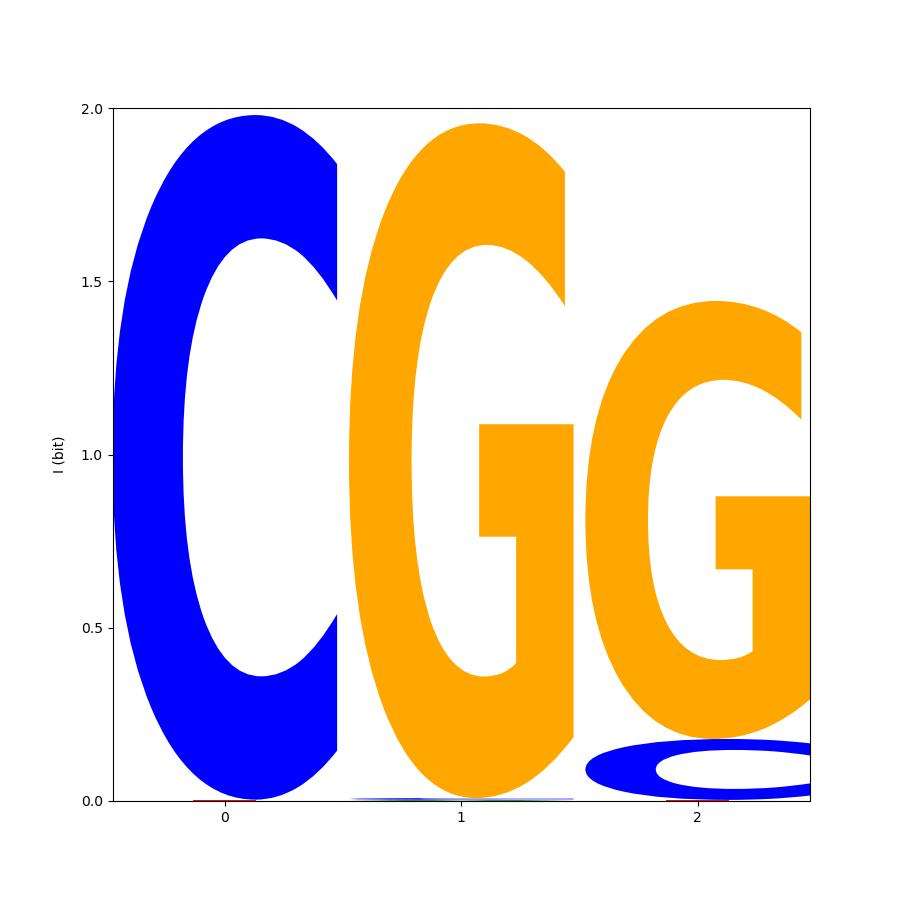
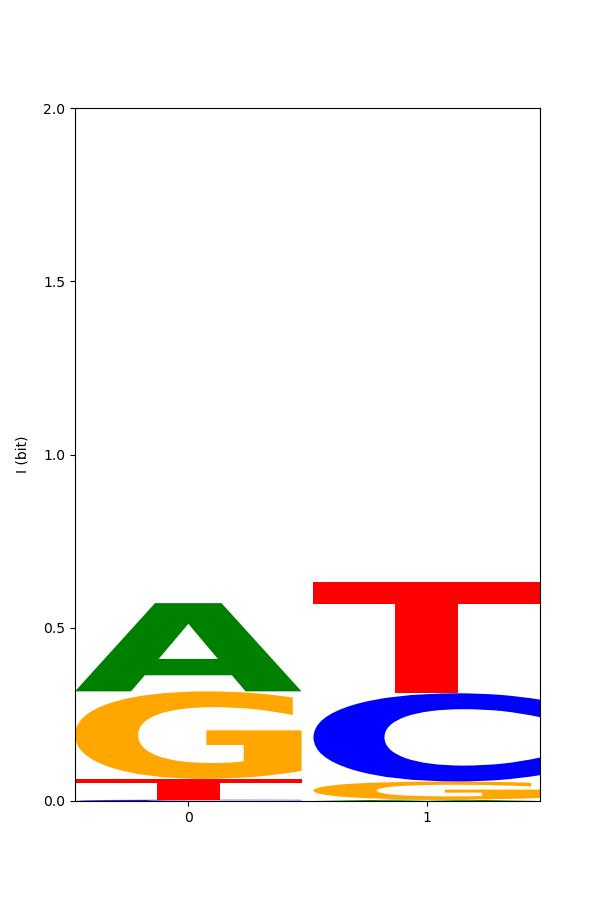
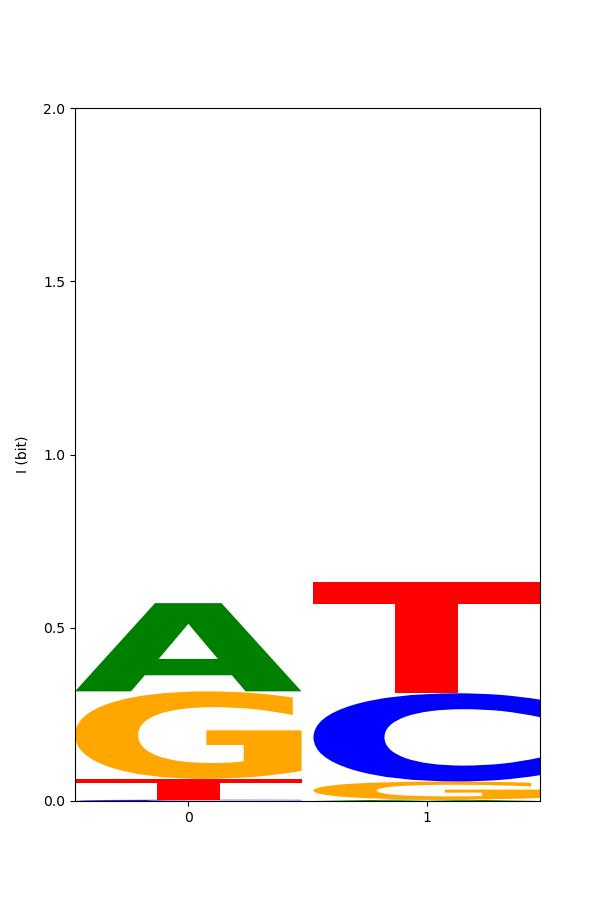

In [11]:
# print & display results from best estimator
model_grid=grid_search.best_estimator_
model_grid.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('best grid', model_grid)
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


,fit_time,score_time,estimator,test_score,train_score,energies,ratio,max binding,r2 hold out test,logo
1,132.231441,0.046317,"findmotif(both_strands=False, fit_G0=True, protein_conc=5)",0.446833,0.453253,"-2015,..",2.717755,0.995426,0.451011,
3,188.052790,0.047175,"findmotif(both_strands=False, fit_G0=True, protein_conc=5)",0.492983,0.440398,"-1863,..",2.391821,0.989307,0.450308,
4,149.130900,0.046196,"findmotif(both_strands=False, fit_G0=True, protein_conc=5)",0.393175,0.466758,"-5091,..",5.364574,1.001567,0.446494,
2,252.500237,0.047304,"findmotif(both_strands=False, fit_G0=True, protein_conc=5)",0.458060,0.448190,"-3285,..",2.941069,1.001786,0.445609,
0,134.164614,0.047976,"findmotif(both_strands=False, fit_G0=True, protein_conc=5)",0.444776,0.452282,"6100,..",2.860521,0.996602,0.441015,

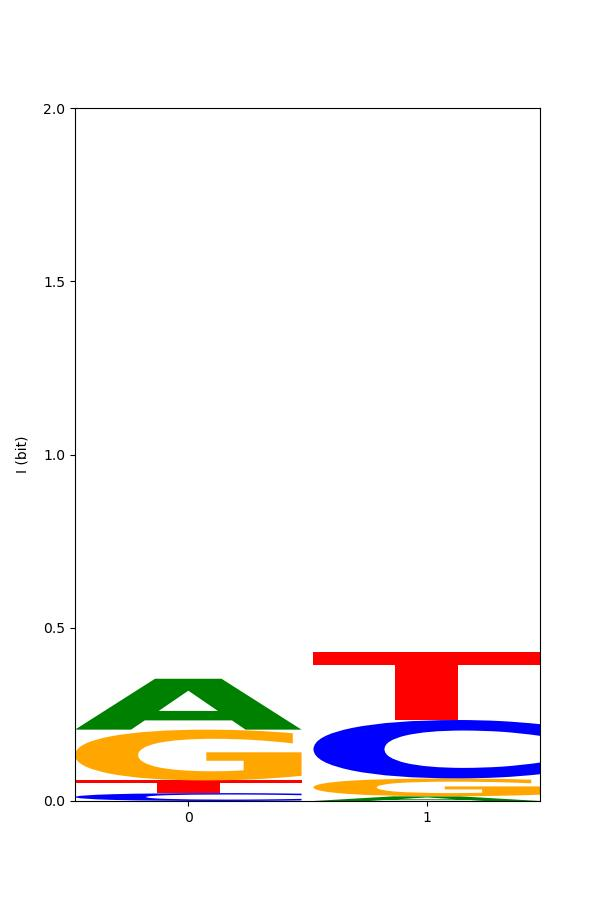
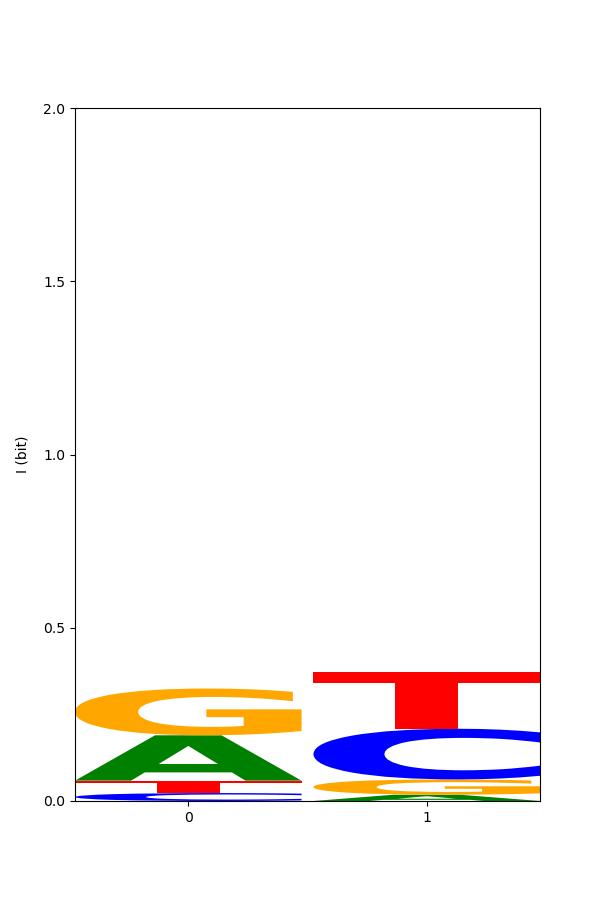
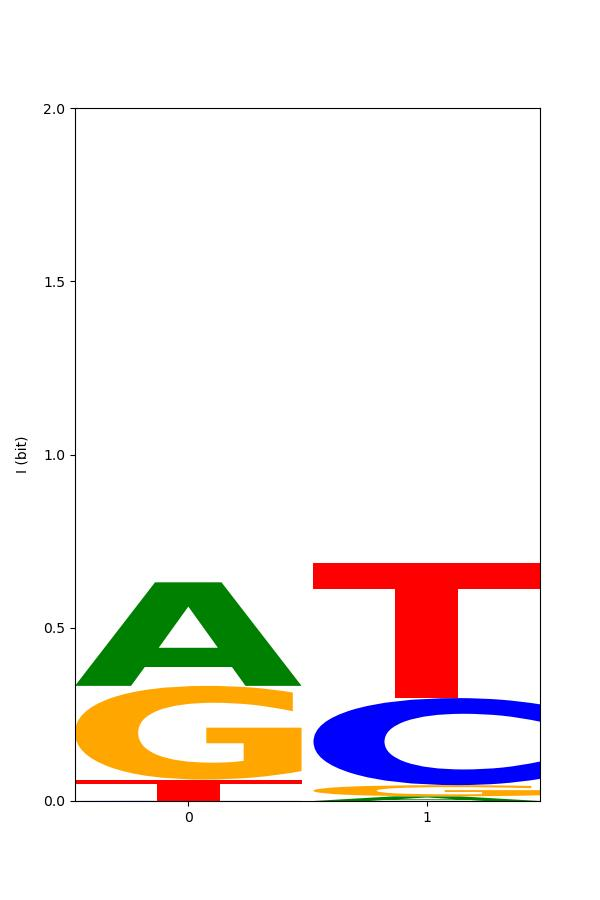
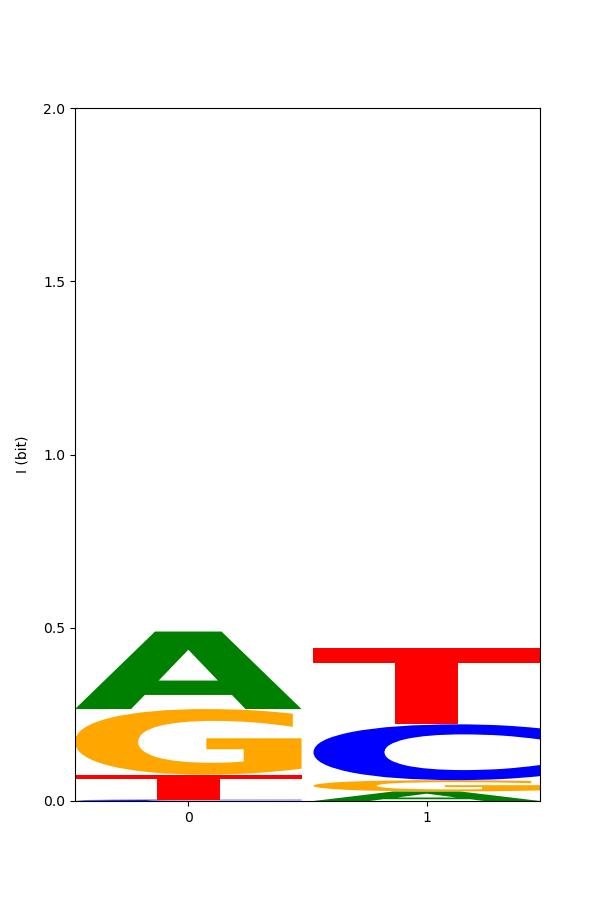
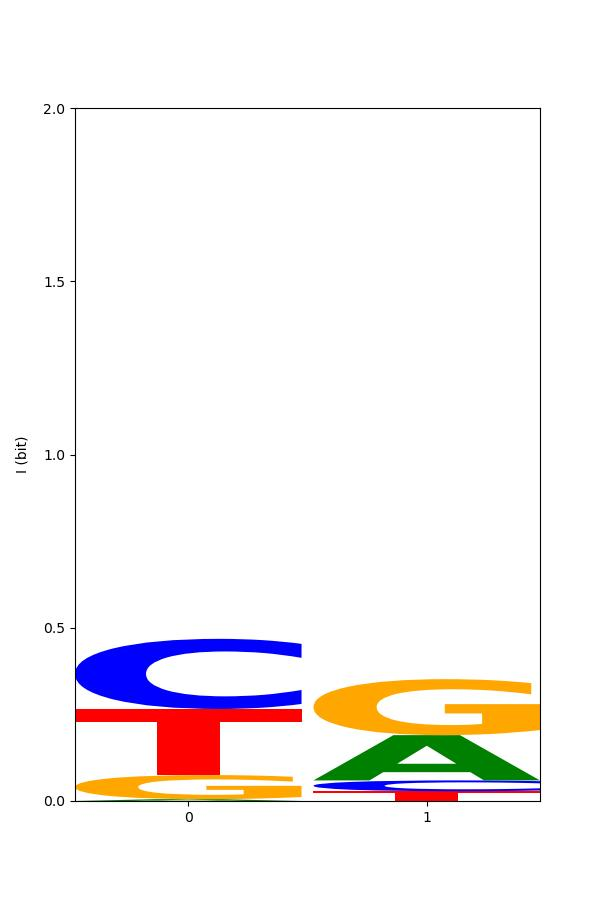

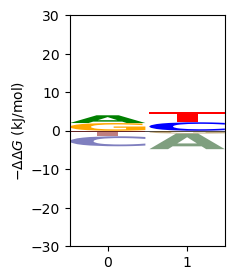

,A,C,G,T
0,-2015.644547,2599.167286,-2009.635328,1426.112590
1,4056.870833,-2203.901288,720.938589,-2573.908135


In [12]:
### run crossvalidation on complete training set
model=mf.findmotif(motif_length=CORE_MOTIF_LENGTH, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS, 
                   fit_G0=True)
result_dict = cross_validate(model, X_train, y_train, cv=5, n_jobs=-1, verbose=10, return_train_score=True, return_estimator=True)
result_df=pd.DataFrame(result_dict)

result_df['energies']=result_df['estimator'].apply(lambda e: e.energies_)
result_df['ratio']=result_df['estimator'].apply(lambda e: e.max_binding_fit/e.min_binding_fit)
result_df['max binding']=result_df['estimator'].apply(lambda e: e.max_binding_fit)
result_df['r2 hold out test']=result_df['estimator'].apply(lambda e: mf.linregress(e.predict(X_test),y_test).rvalue**2)
result_df.sort_values('r2 hold out test', ascending=False, inplace=True)
mf.display_df(result_df, nuc_type=NUC_TYPE)
best_energies_cv_core_length=result_df.iloc[0].at['energies']
mf.energies2energylogo(best_energies_cv_core_length, nuc_type=NUC_TYPE)

  0%|          | 0/16 [00:00<?, ?engine/s]

single_job:   0%|          | 0/20 [00:00<?, ?tasks/s]

I: Optimization took 0.21 hours.
I: Results of the repeated motif finding, sorted according to the regression coefficient with the train dataset


,model,r (train),r (test),G0,max binding,min binding,ratio,energies,logo
1,suppressed,0.673682,0.670489,-12851.653695,1.013139,0.207227,4.889024,"-5521,..",
7,suppressed,0.673454,0.670458,-16002.879874,1.003394,0.221901,4.521807,"-3512,..",
10,suppressed,0.672368,0.665185,-16193.484922,1.003566,0.242678,4.135382,"8991,..",
6,suppressed,0.672349,0.665097,-16620.813934,0.998402,0.251515,3.969556,"8032,..",
17,suppressed,0.672285,0.665293,-15924.724153,1.003268,0.230609,4.350519,"8894,..",
14,suppressed,0.672172,0.665095,-16652.089445,1.005409,0.236505,4.251108,"6546,..",
3,suppressed,0.672167,0.664827,-17439.647788,1.000066,0.272970,3.663646,"5924,..",
12,suppressed,0.672040,0.663957,-18198.781596,1.002839,0.332866,3.012737,"5431,..",
19,suppressed,0.671940,0.664776,-15666.445592,1.003009,0.220799,4.542639,"5647,..",
4,suppressed,0.671900,0.664521,-17196.836627,1.003644,0.254532,3.943090,"4928,..",

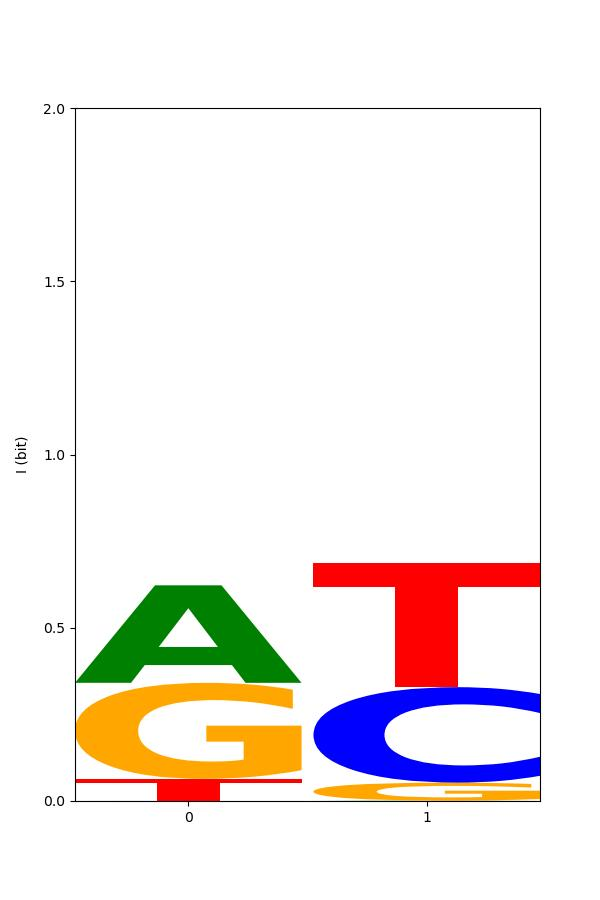
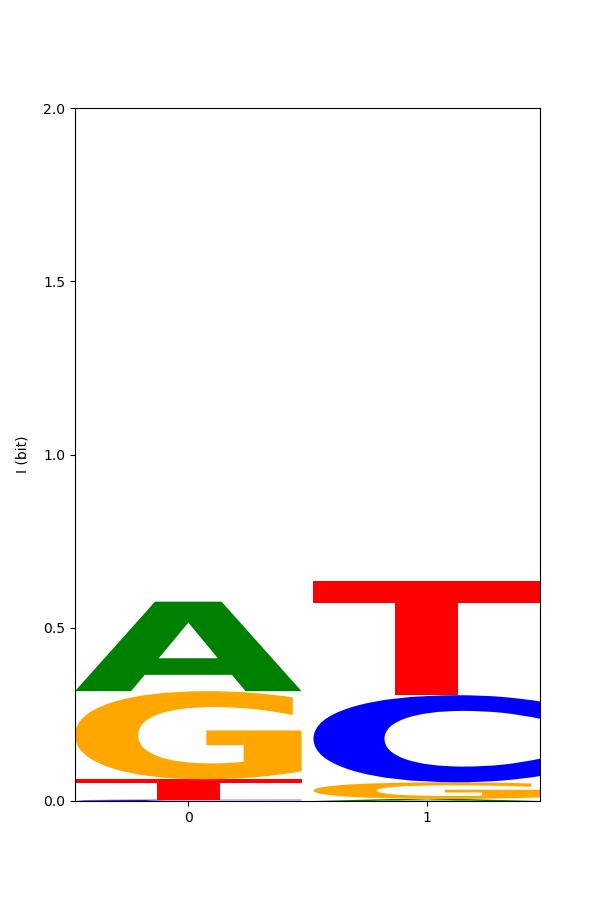
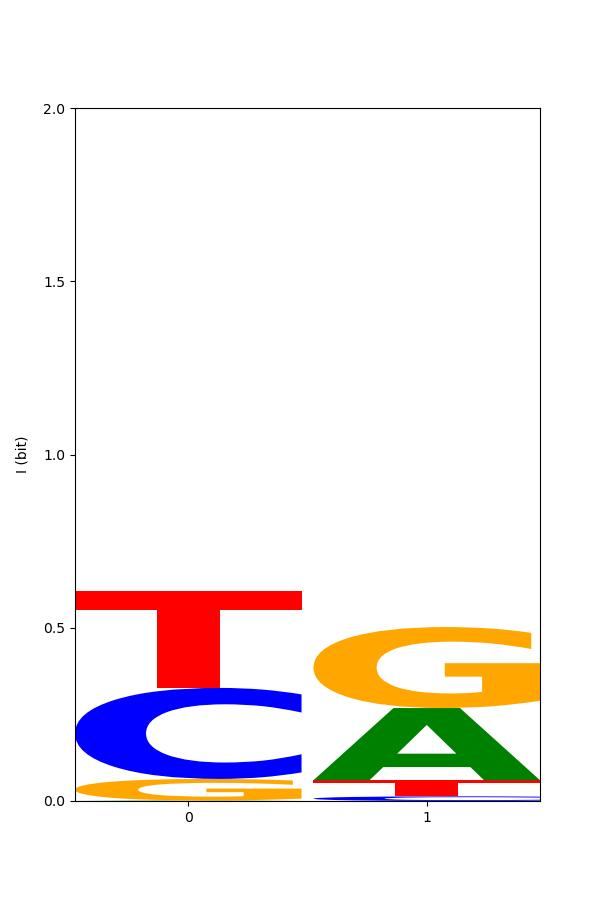
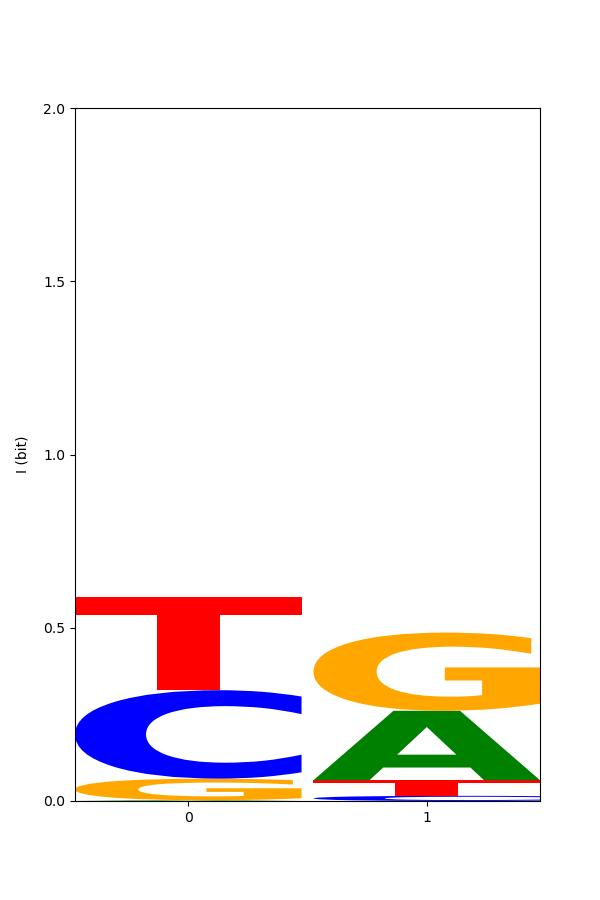
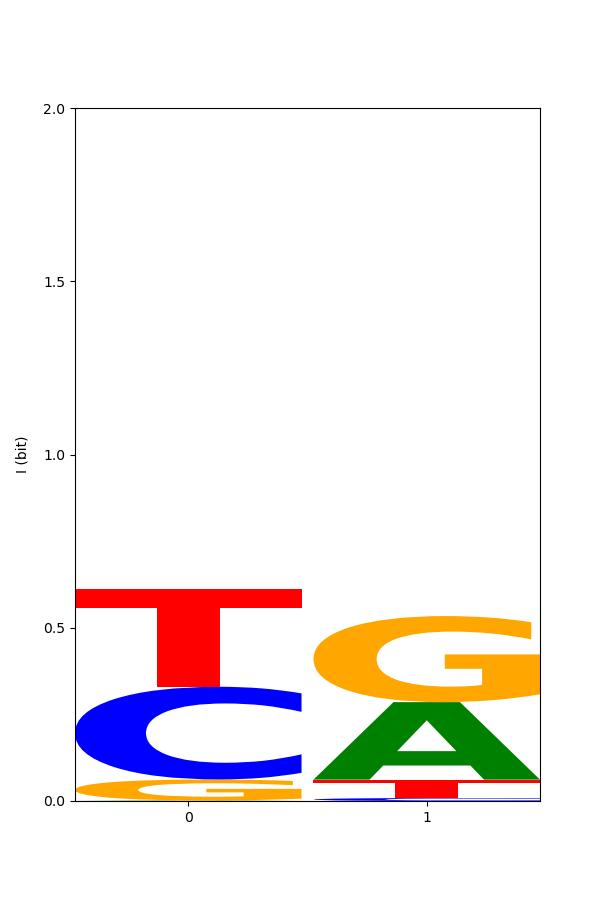
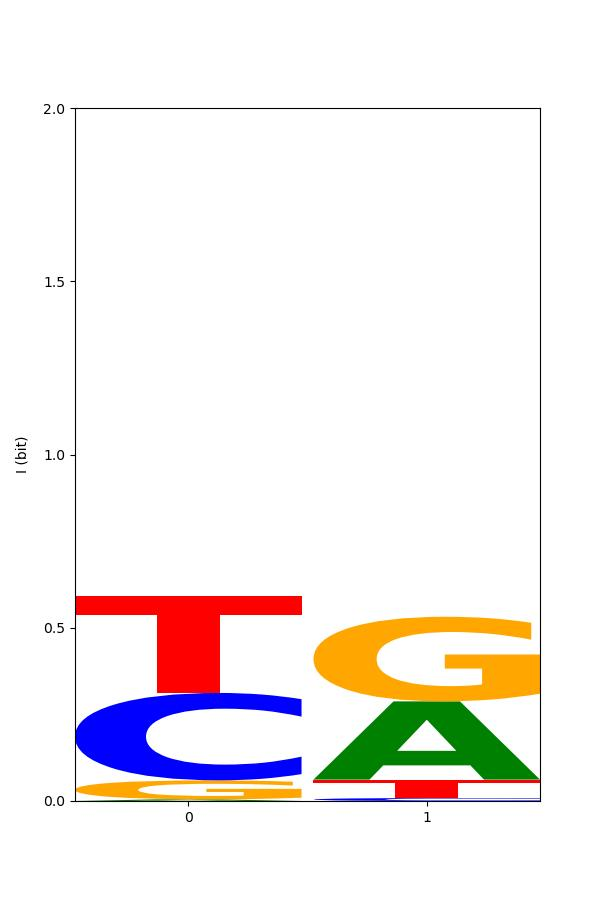
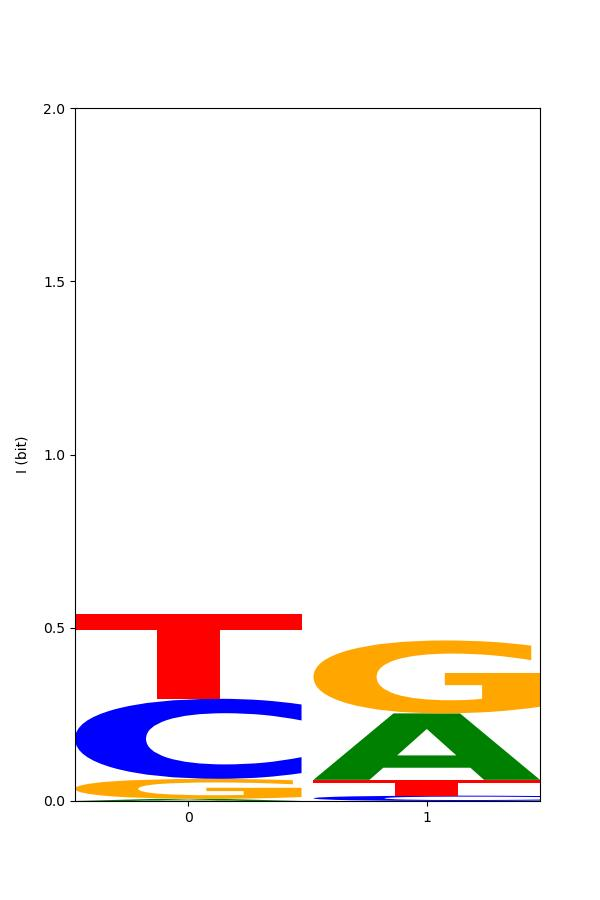
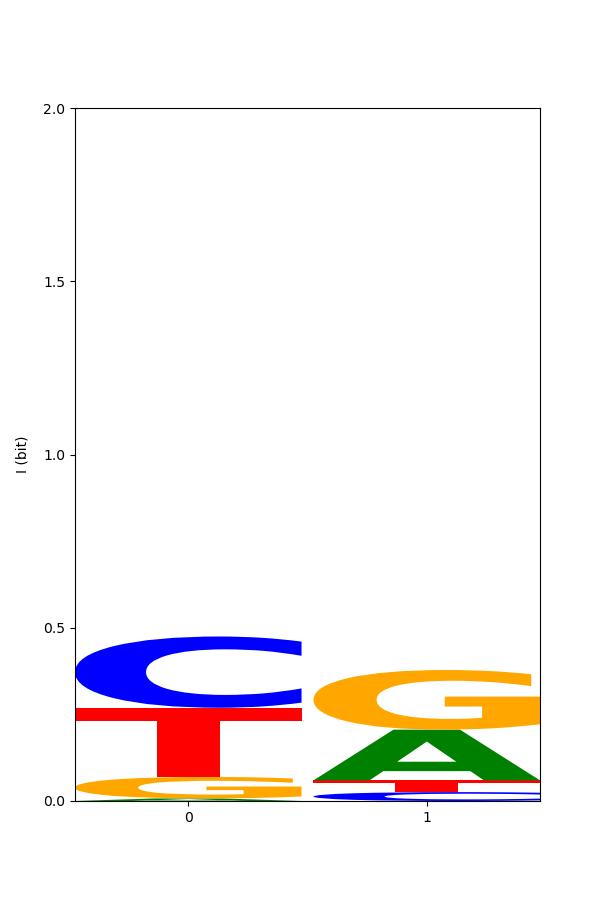
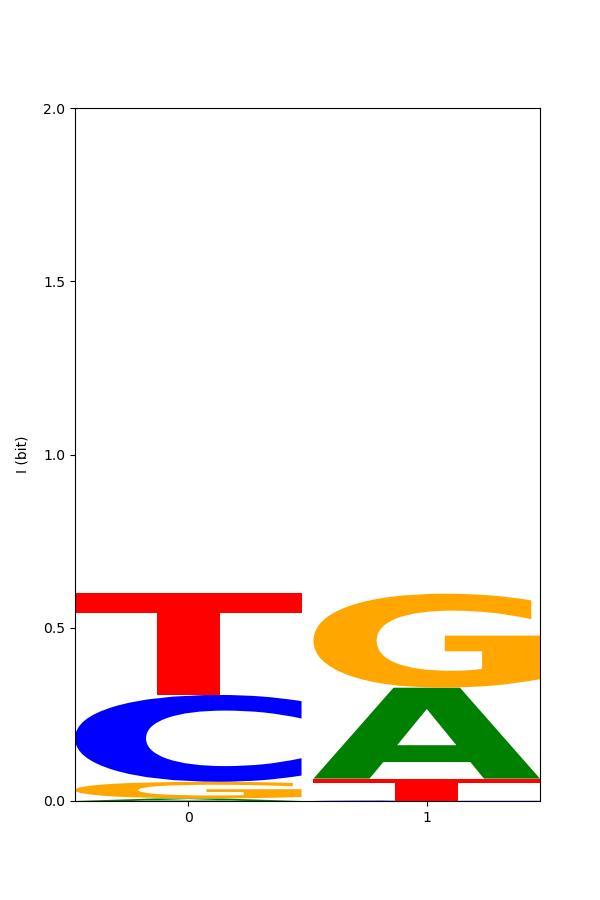
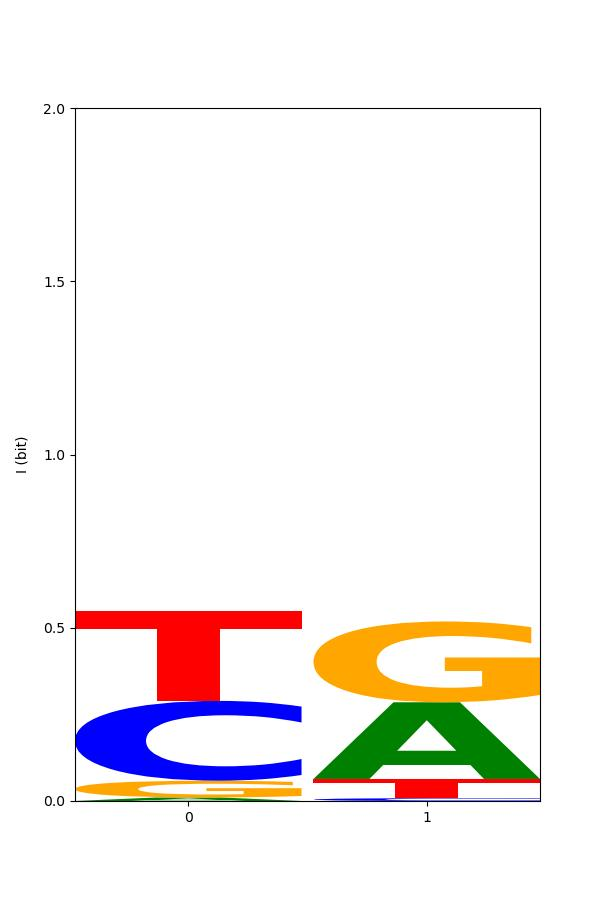
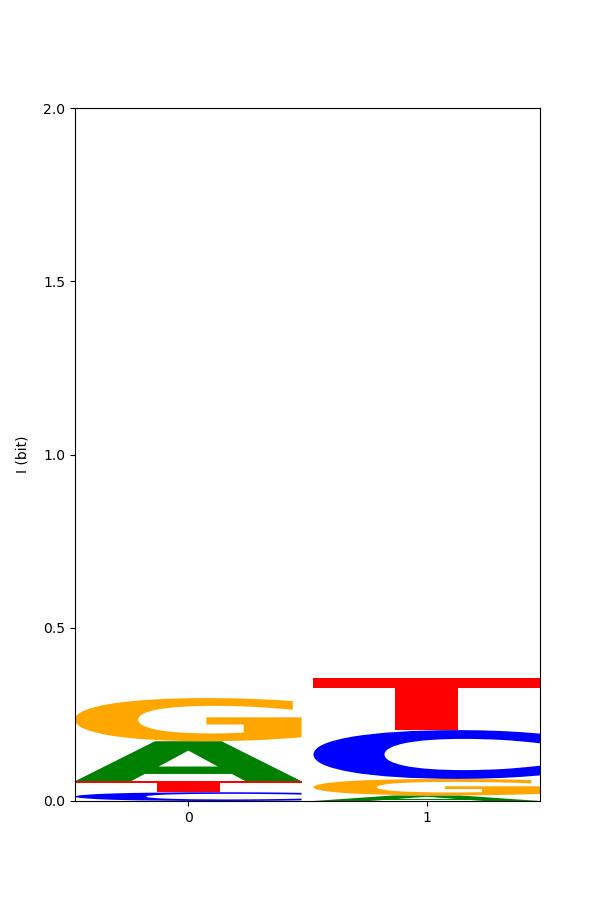
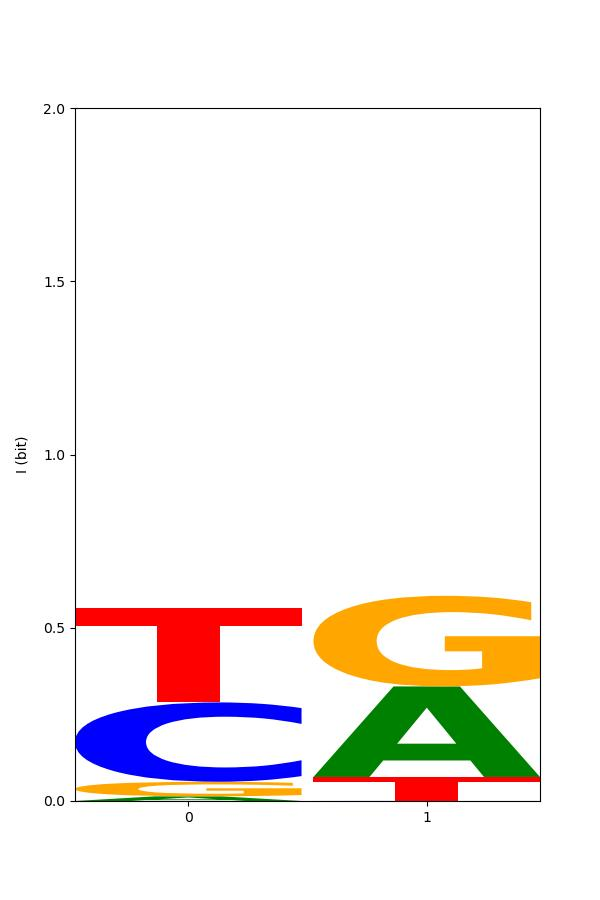
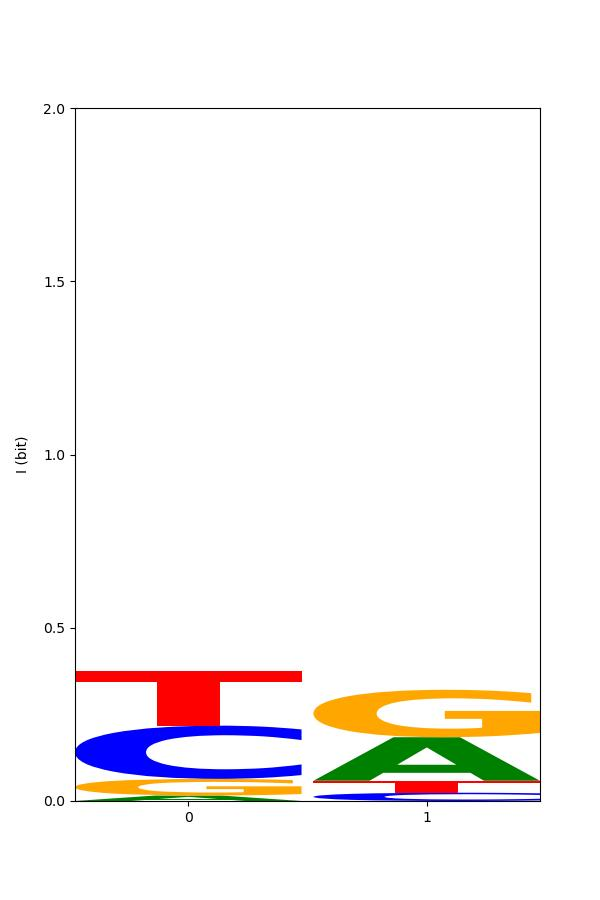
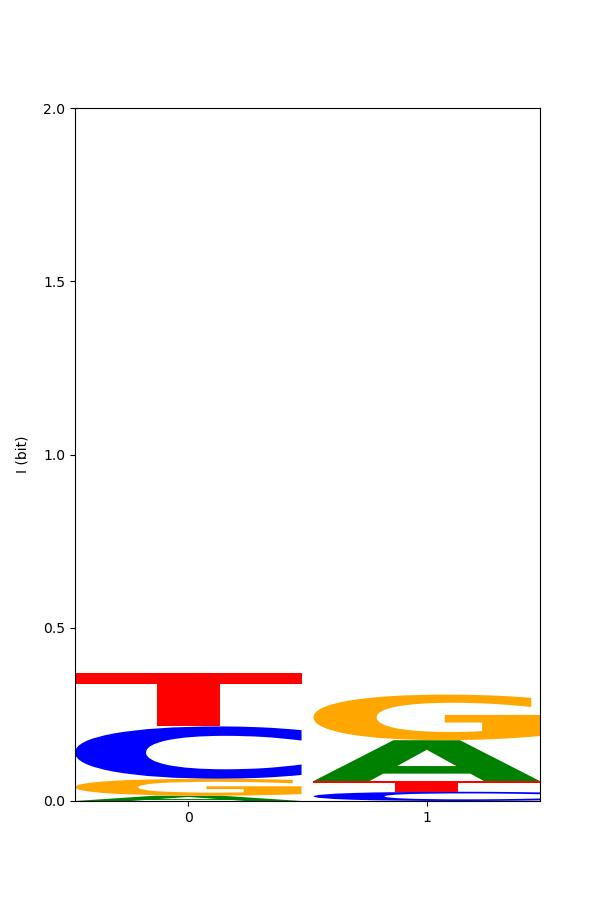
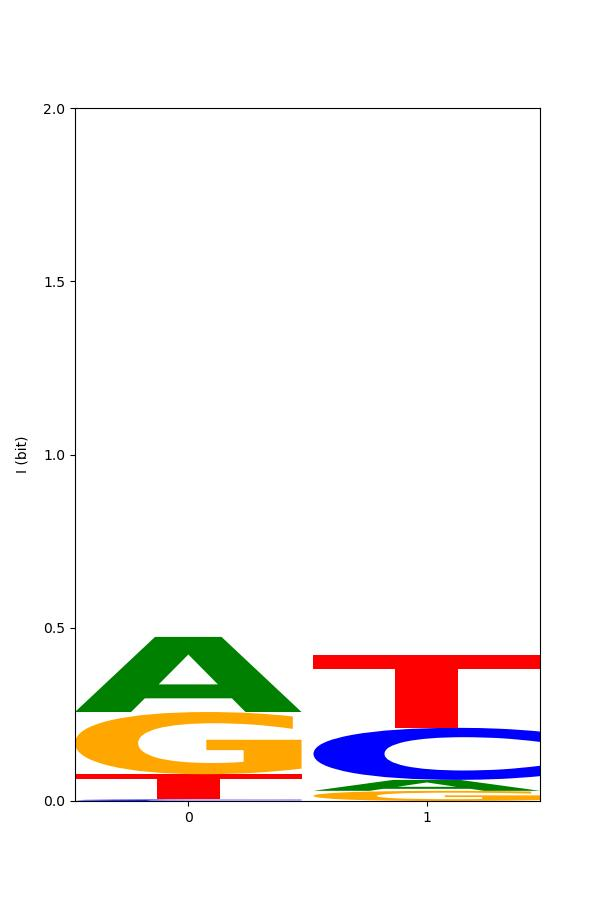
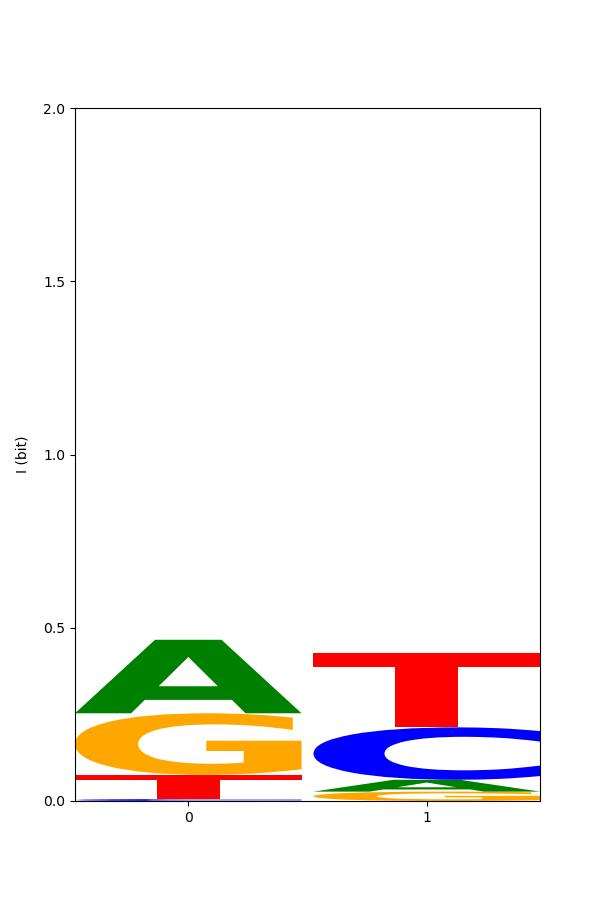
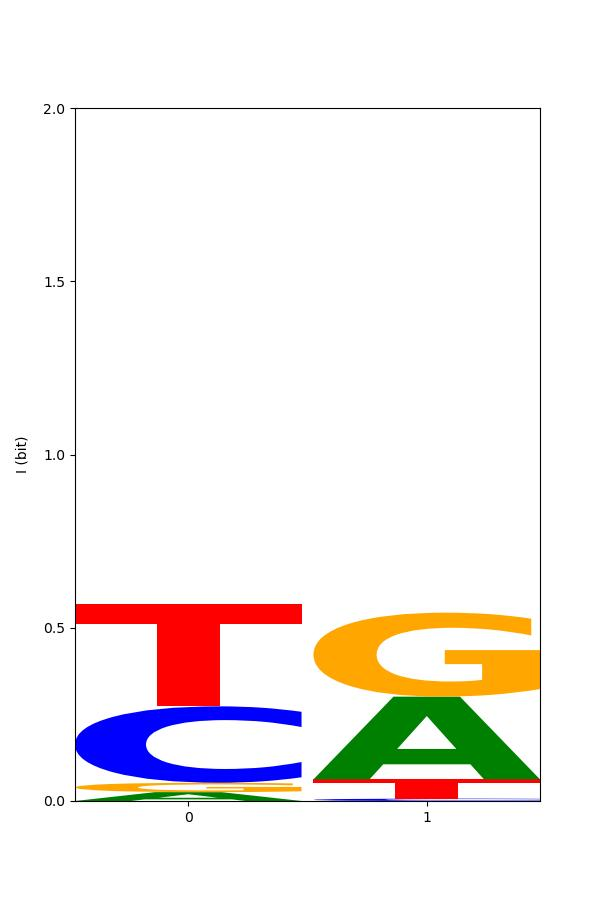
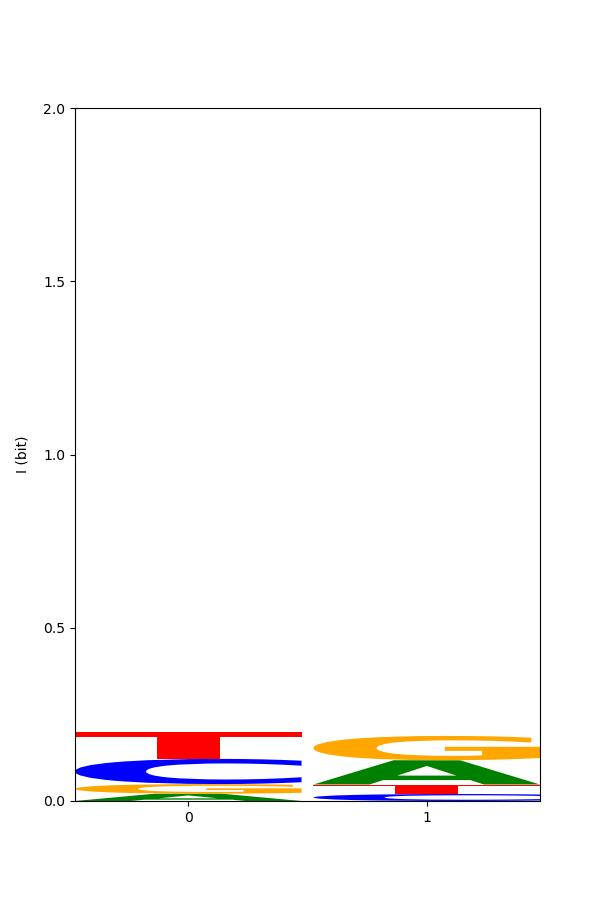
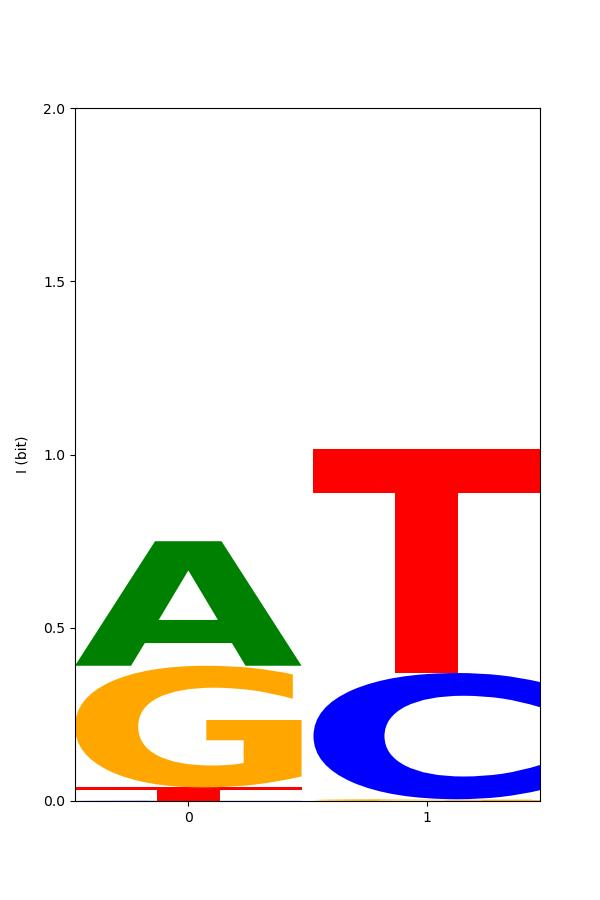
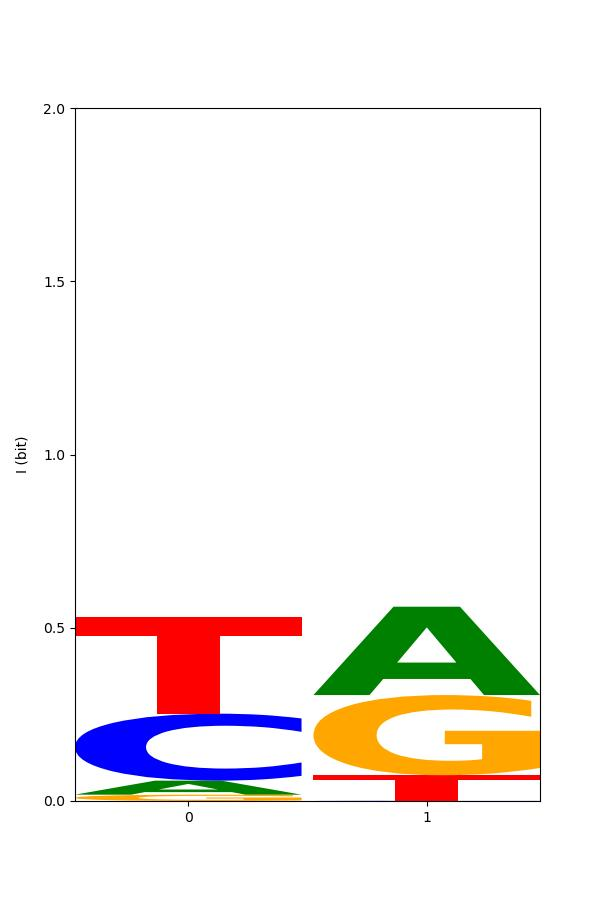

In [13]:
### run a number of identical optimizations with motif length found during grid search
### goal: find best motif through repetition, judge stabiltiy of optimization

#CORE_MOTIF_LENGTH=5  # adjust core motif length if needed, motif length can be changed later

# prepare for ipyparallel
number_of_optimizations = 20
model_list = [mf.findmotif(motif_length=CORE_MOTIF_LENGTH, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS, fit_G0=True)] * number_of_optimizations
X_list = [X_train] * number_of_optimizations
y_list = [y_train] * number_of_optimizations


def single_job(model, X, y):
    model.fit(X, y)
    return {'model':model}

# run the optimizations on ipp.cluster
start = time()
with ipp.Cluster(log_level=40) as rc:
    rc[:].use_pickle()
    view = rc.load_balanced_view()
    asyncresult = view.map_async(single_job, model_list, X_list, y_list)
    asyncresult.wait_interactive()
    result = asyncresult.get()
print("I: Optimization took %.2f hours." % ((time() - start) / 3600))


  
# assemble results and analyze
df_repetitions=pd.DataFrame(result)
df_repetitions['r (train)']=df_repetitions['model'].apply(lambda e: mf.linregress(e.predict(X_train),y_train).rvalue)
df_repetitions['r (test)']=df_repetitions['model'].apply(lambda e: mf.linregress(e.predict(X_test),y_test).rvalue)
df_repetitions['G0']=df_repetitions['model'].apply(lambda e: e.finalG0_)
df_repetitions['max binding']=df_repetitions['model'].apply(lambda e: e.max_binding_fit)
df_repetitions['min binding']=df_repetitions['model'].apply(lambda e: e.min_binding_fit)
df_repetitions['ratio'] = df_repetitions['model'].apply(lambda e: e.ratio)
df_repetitions['energies']=df_repetitions['model'].apply(lambda e: e.energies_)
#df_repetitions['information']=df_repetitions['model'].apply(lambda e: mf.energies2information(e.energies_))


# display results of the ensemble of optimizations
print('I: Results of the repeated motif finding, sorted according to the regression coefficient with the train dataset')
df_repetitions.sort_values('r (train)', ascending=False, inplace=True)
mf.display_df(df_repetitions, nuc_type=NUC_TYPE)

I: Histogram of the regression coefficients r obtained by repeated optimizaion with the subset.


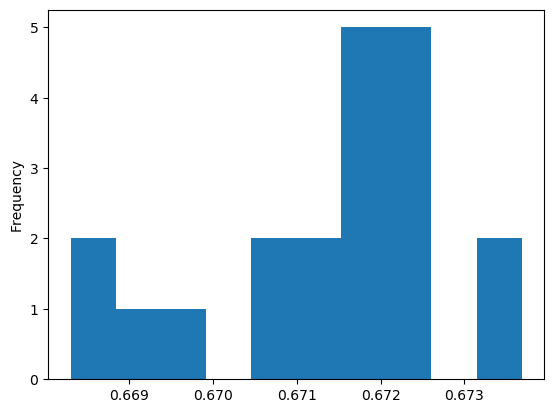

I: 2-dimensional PCA explained 94 % of variance.
I: Visualization of the PCA with the regression quality vs. subset and training dataset by color.


/home/GLipps/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


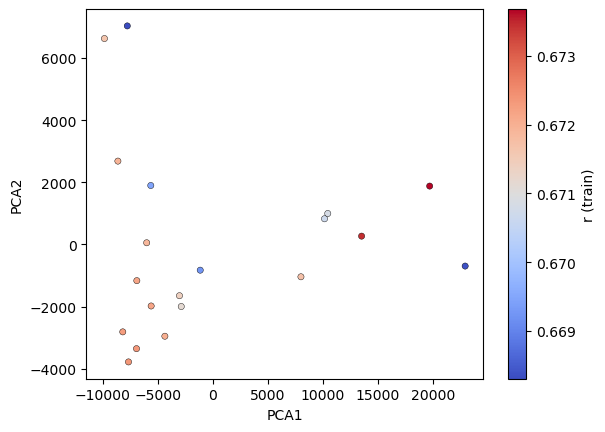

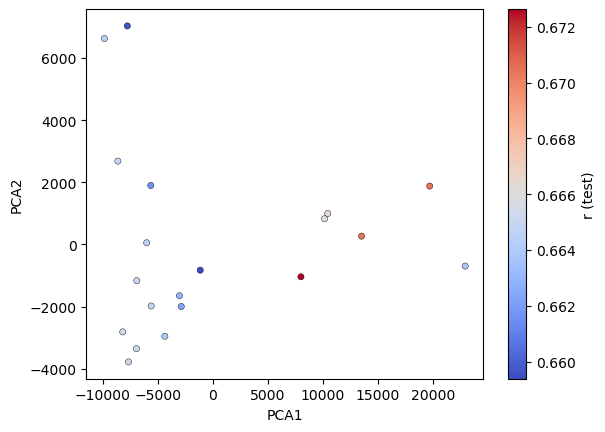

In [14]:
### compare energy matrices of ensemble using PCA
print('I: Histogram of the regression coefficients r obtained by repeated optimizaion with the subset.')
df_repetitions['r (train)'].plot(kind='hist')
plt.show()

pca = PCA(n_components=2)
pca_2c=pca.fit_transform(df_repetitions['energies'].tolist())    
df_repetitions[['PCA1', 'PCA2']]=pca_2c
print('I: 2-dimensional PCA explained %i %% of variance.' %(sum(pca.explained_variance_ratio_)*100))
if sum(pca.explained_variance_ratio_)<0.5:
      print('W: 2-dimensional PCA explained only %i %% of variance' %(sum(pca.explained_variance_ratio_)*100))

print('I: Visualization of the PCA with the regression quality vs. subset and training dataset by color.')        
df_repetitions.plot(x='PCA1', y='PCA2', kind='scatter', c='r (train)',cmap=cm.coolwarm, edgecolors='black', linewidths=0.3)
df_repetitions.plot(x='PCA1', y='PCA2', kind='scatter', c='r (test)',cmap=cm.coolwarm, edgecolors='black', linewidths=0.3)

I: Best motif according to r (train) from the repeated optimizations.
I: PCA components: 19712, 1878
I: energy matrix and logos:



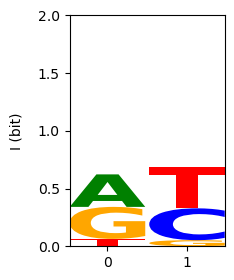

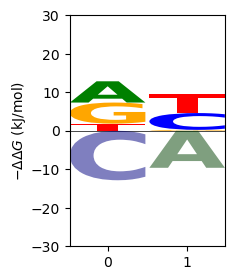


       A      C     G     T
0 -5521  12852 -5484 -1846
1  9614  -4366  -236 -5010

I: summed absolute energies of each position:
0    25704
1    19228
dtype: int64

I: averaged summed energy over all positions: 22466
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -12651 +/- 8999
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


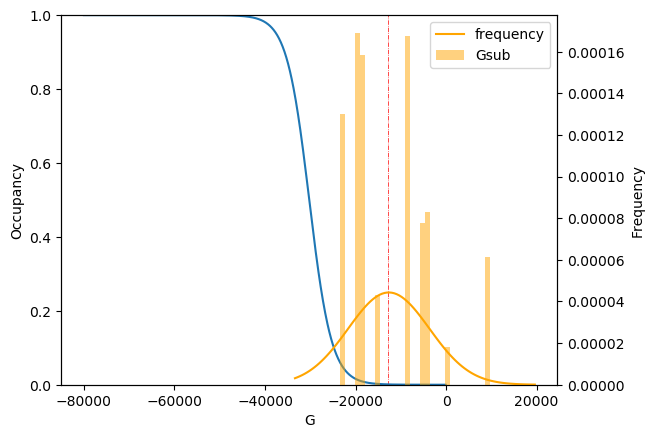

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.20723 .. 1.01314 (ratio: 4.9)
I: number of probes: 2519
I: Pearson Correlation  r: 0.6737
I: mean absolute error: 0.1124


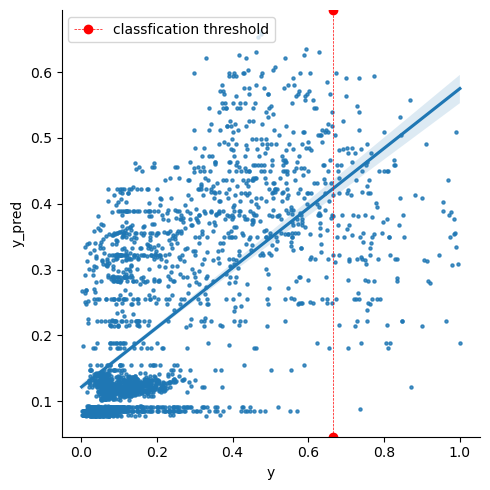

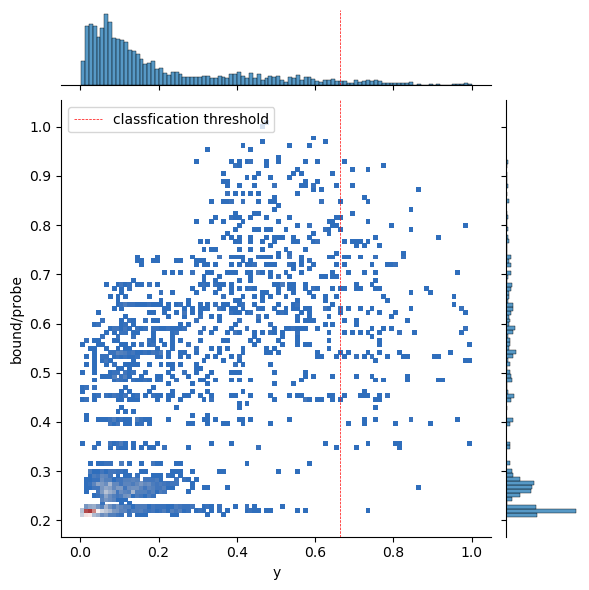

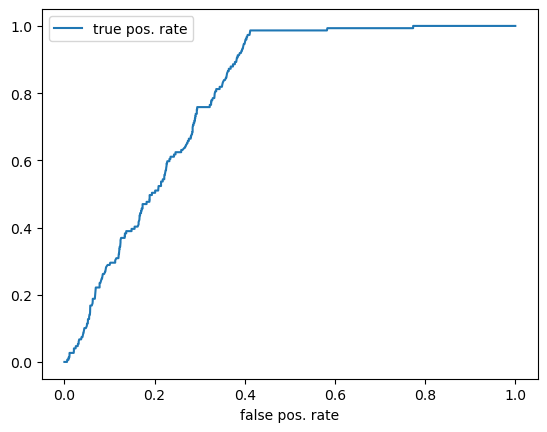

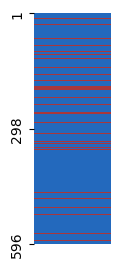

I: Classification performance AUROC: 0.7945


,stage,protein,# probes,motif length,r,AUROC,G0,G0 fitted,ratio,max binding,min binding,energies,model,logo,r (test)
0,quick,T7 primase,100,3,0.659047,0.794163,-1785.711179,False,192.719840,4.218337,0.021888,"11057,..",suppressed,,NaN
1,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,,NaN
2,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,,NaN
3,best repetition,T7 primase,2519,2,0.673682,0.794494,-12851.653695,True,4.889024,1.013139,0.207227,"-5521,..",suppressed,,0.670489

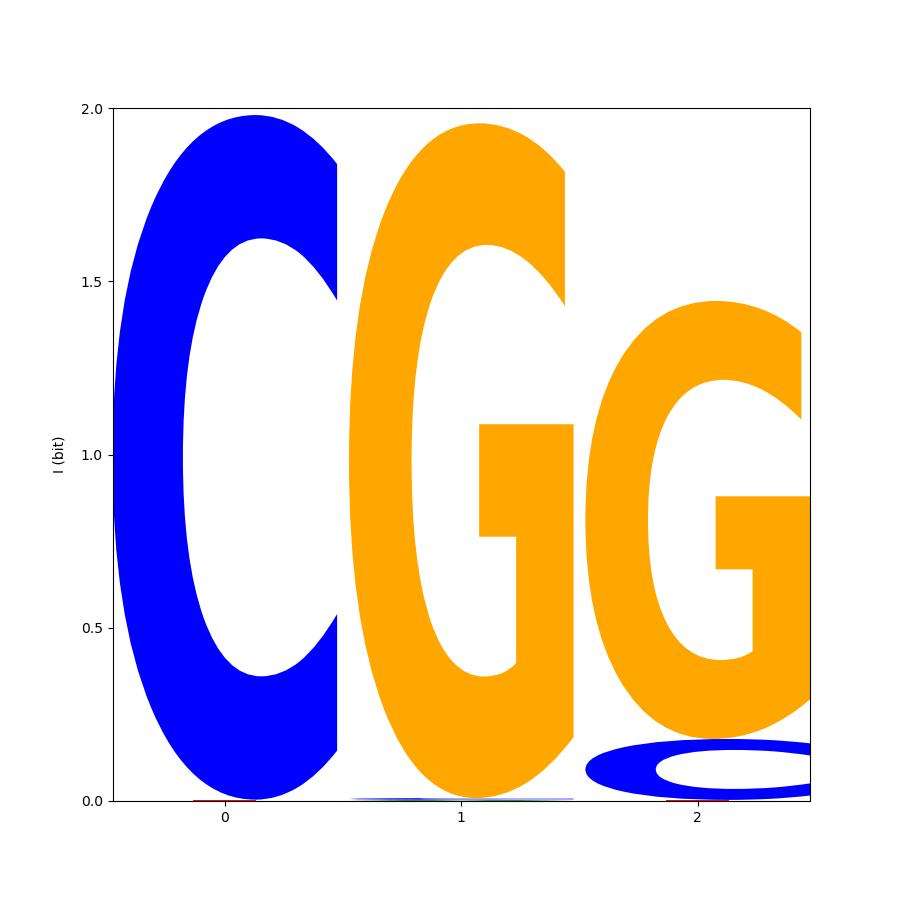
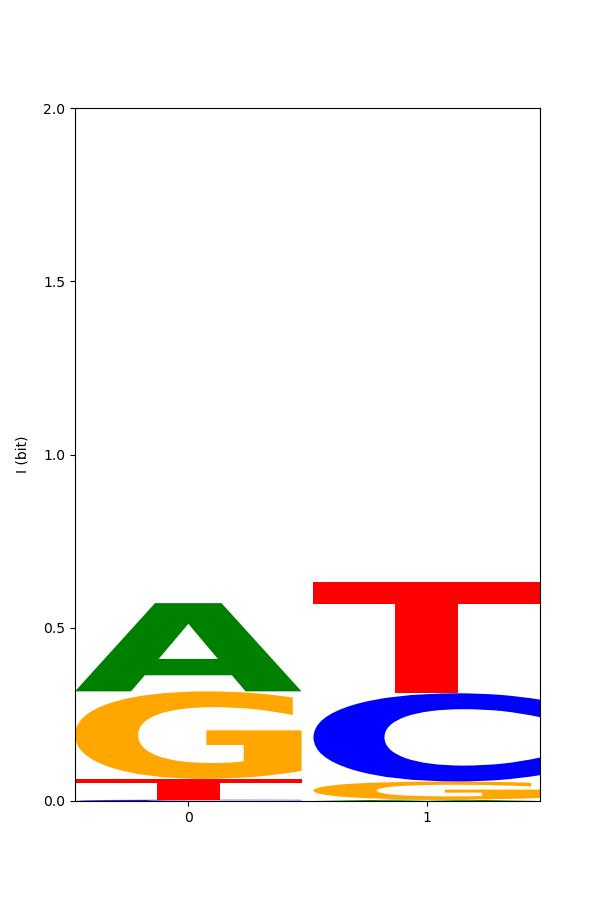
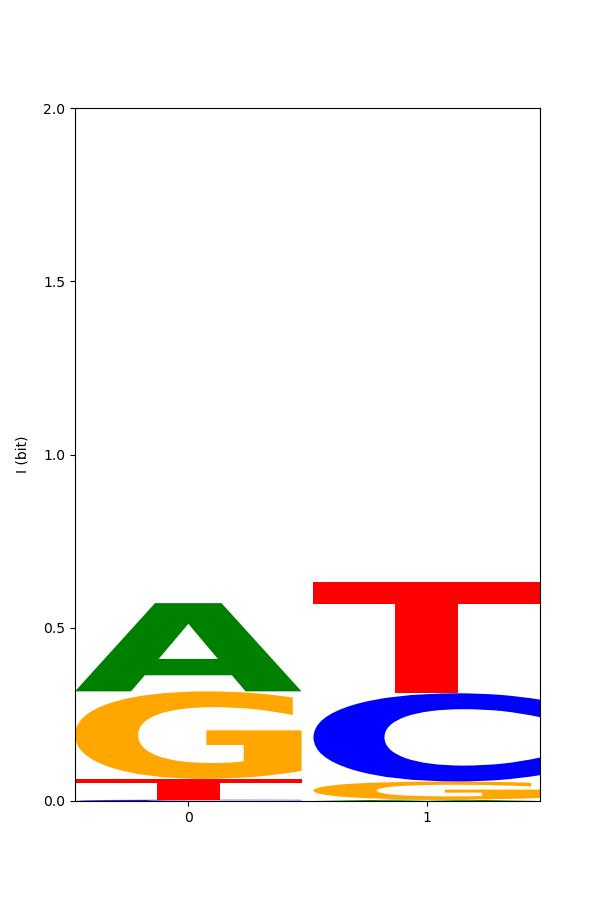
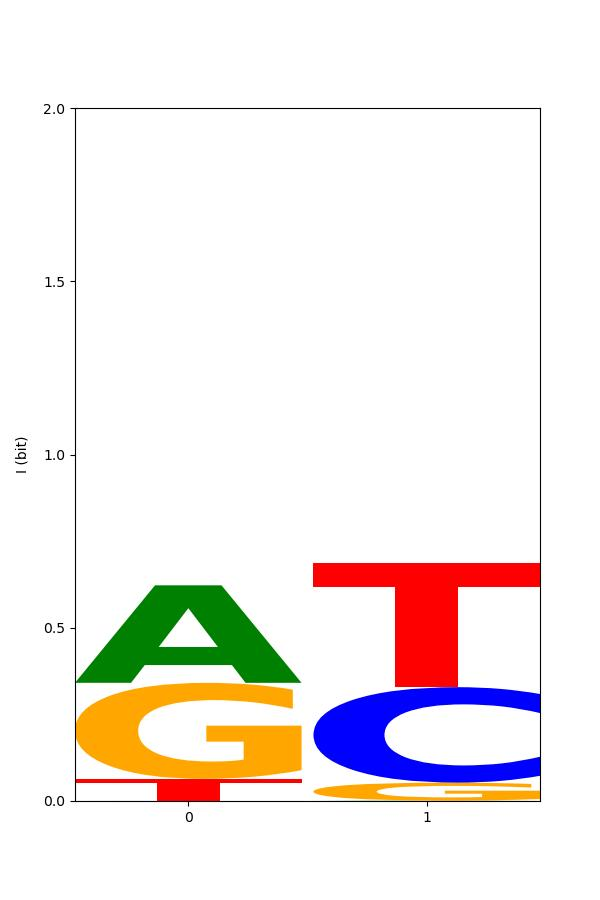

In [15]:
# visualisation of the motif with the highest r with the train dataset
print('I: Best motif according to r (train) from the repeated optimizations.')
print('I: PCA components: %i, %i' %(df_repetitions.iloc[0]['PCA1'], df_repetitions.iloc[0]['PCA2']))
model_best_repetition=df_repetitions.iloc[0]['model']
model_best_repetition.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE) 
# store results and display stages
STAGES.append('best repetition', model_best_repetition, new_entries={'r (test)': mf.linregress(model_best_repetition.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

Optimization terminated successfully.
         Current function value: 0.106085
         Iterations: 1
         Function evaluations: 153
I: energy matrix and logos:



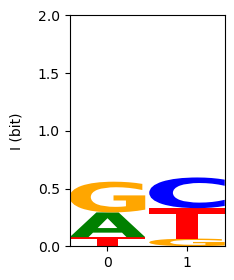

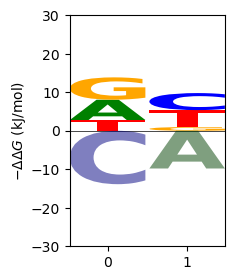


       A      C     G     T
0 -5274  13873 -5804 -2794
1  9795  -4424  -964 -4406

I: summed absolute energies of each position:
0    27746
1    19590
dtype: int64

I: averaged summed energy over all positions: 23668
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -12630 +/- 9592
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


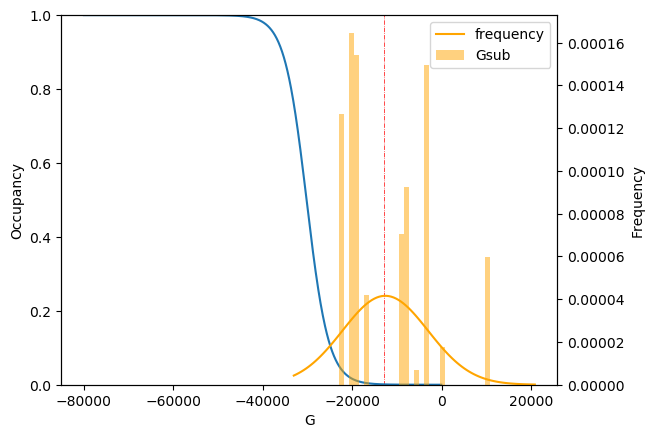

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.21109 .. 0.95935 (ratio: 4.9)
I: number of probes: 2519
I: Pearson Correlation  r: 0.6656
I: mean absolute error: 0.1061


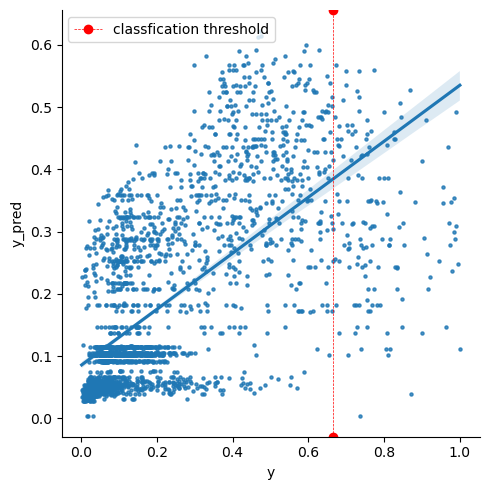

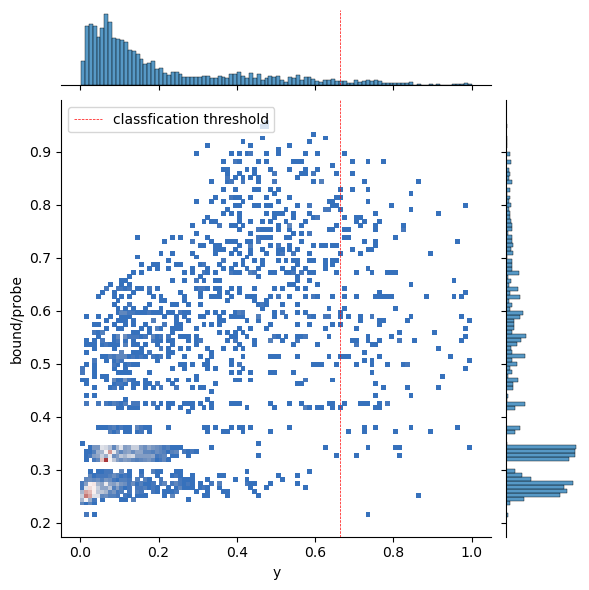

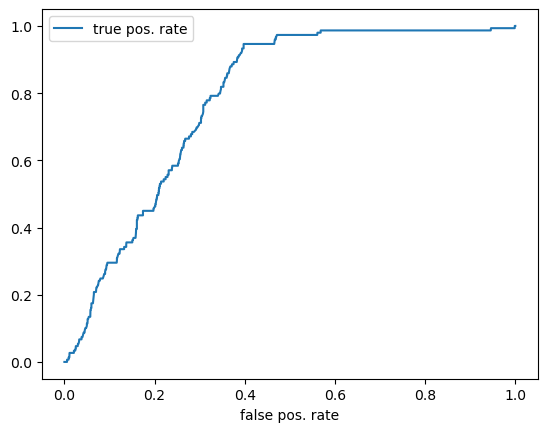

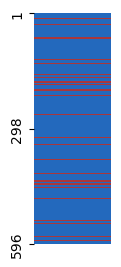

I: Classification performance AUROC: 0.7827


,stage,protein,# probes,motif length,r,AUROC,G0,G0 fitted,ratio,max binding,min binding,energies,model,logo,r (test)
0,quick,T7 primase,100,3,0.659047,0.794163,-1785.711179,False,192.719840,4.218337,0.021888,"11057,..",suppressed,,NaN
1,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,,NaN
2,best grid,T7 primase,2519,2,0.673533,0.792705,-15766.748132,True,4.368759,0.999388,0.228758,"-3539,..",suppressed,,NaN
3,best repetition,T7 primase,2519,2,0.673682,0.794494,-12851.653695,True,4.889024,1.013139,0.207227,"-5521,..",suppressed,,0.670489
4,"train, mae optimzed",T7 primase,2519,2,0.665595,0.782710,-12851.653695,True,4.889024,0.959347,0.211093,"-5274,..",suppressed,,0.668123

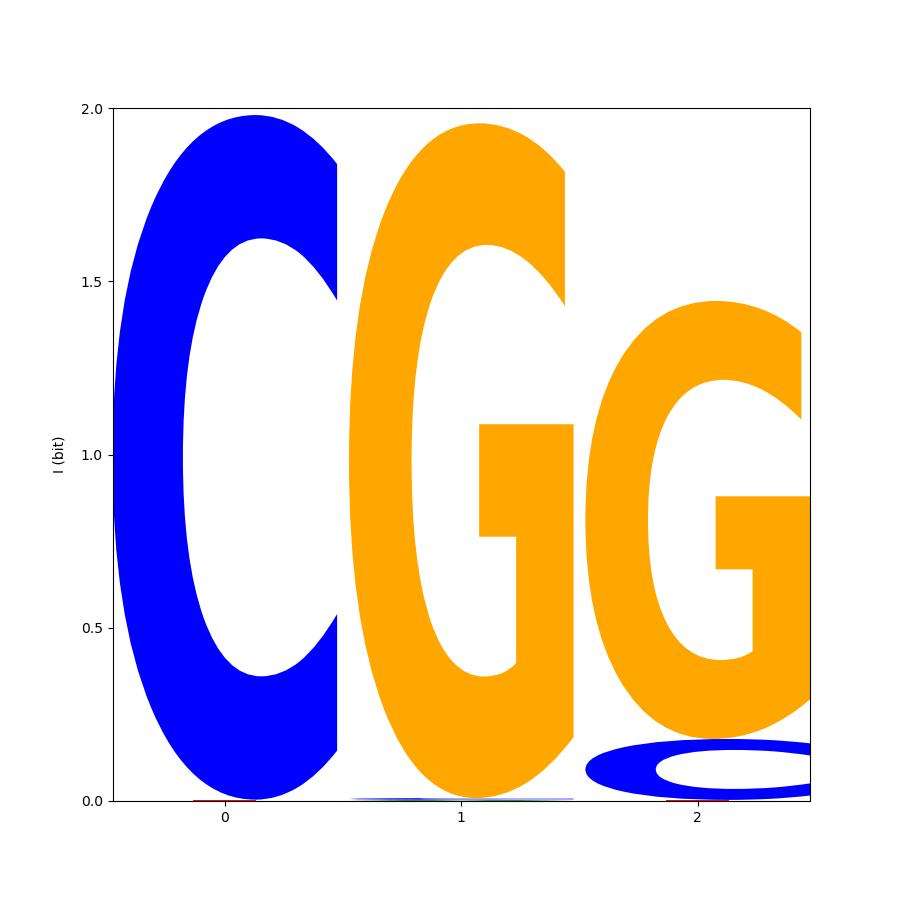
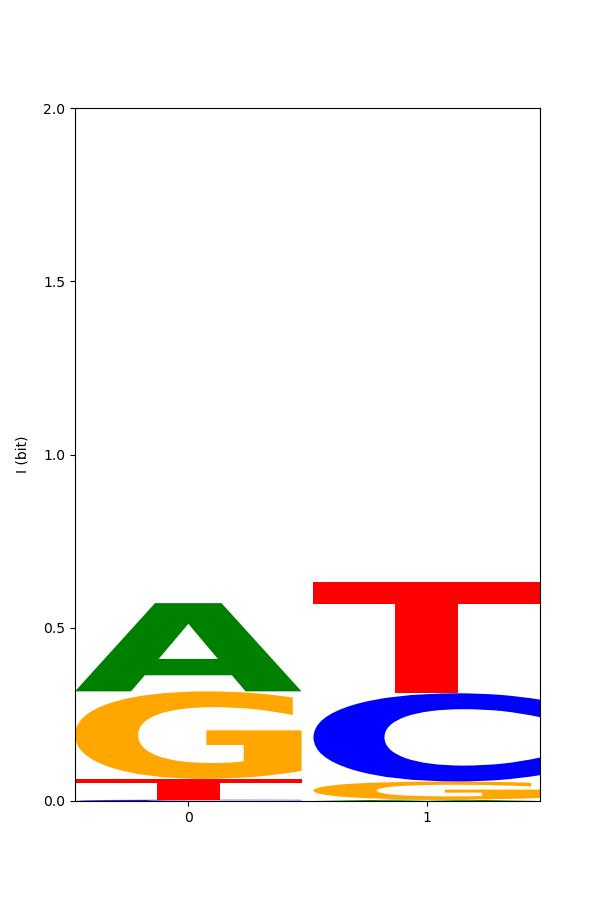
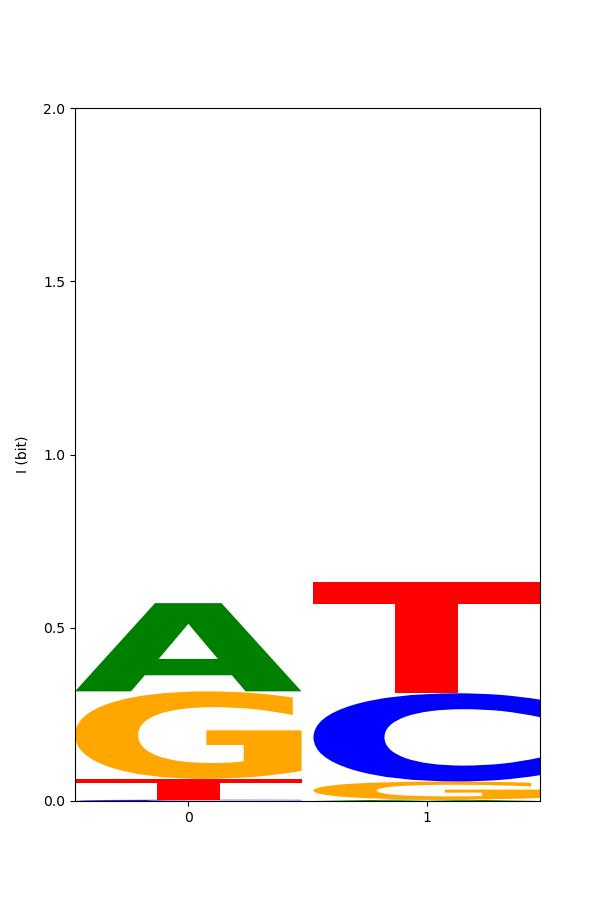
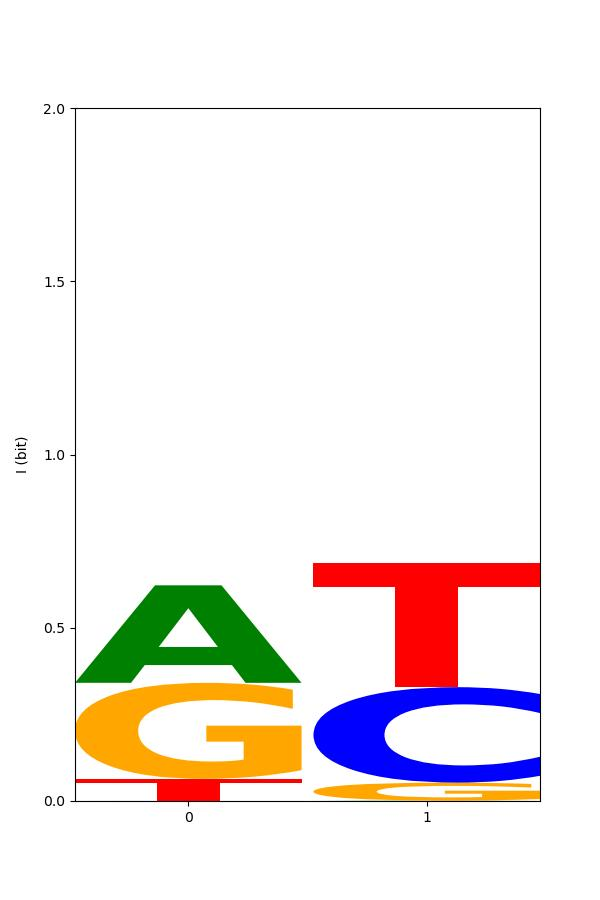
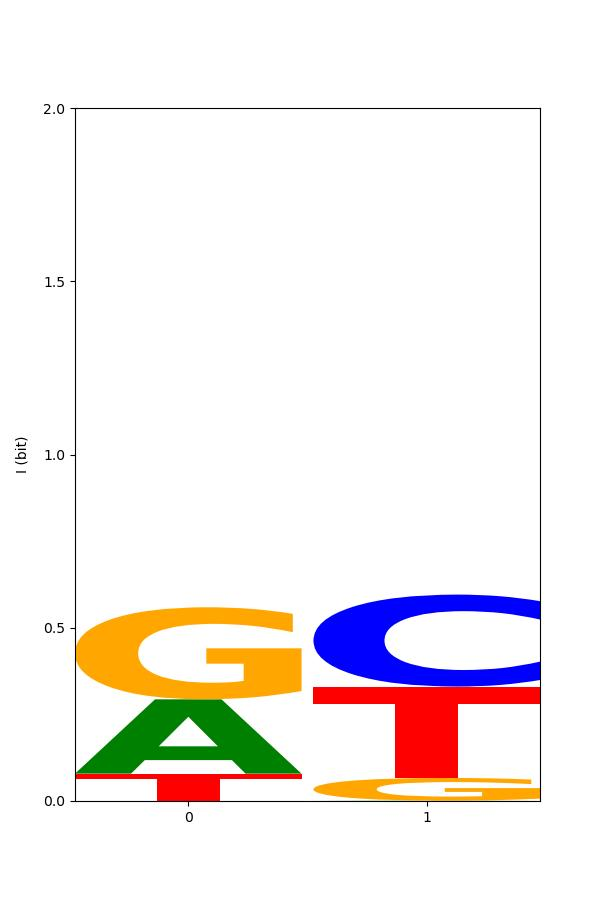

In [17]:
# refit model to minimize mae
last_model=STAGES.df.at[max(STAGES.df.index),'model']
refitted_model_best_repetition=model_best_repetition.refit_mae(X_train,y_train)

# print & display main results
refitted_model_best_repetition.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, mae optimzed', refitted_model_best_repetition, new_entries={'r (test)': mf.linregress(refitted_model_best_repetition.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

  0%|          | 0/6 [00:00<?, ?engine/s]

job5:   0%|          | 0/3 [00:00<?, ?tasks/s]

job3:   0%|          | 0/3 [00:00<?, ?tasks/s]

I: Optimization took 0.01 hours.


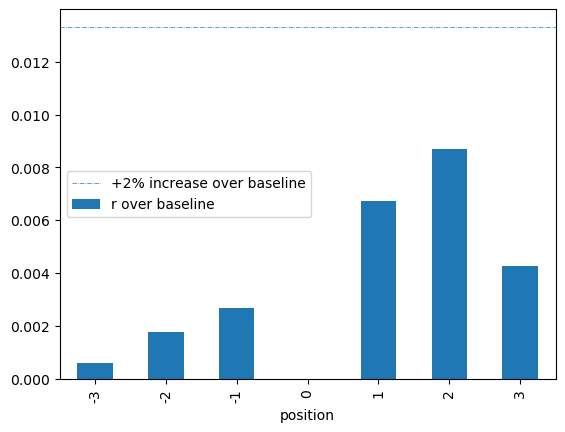

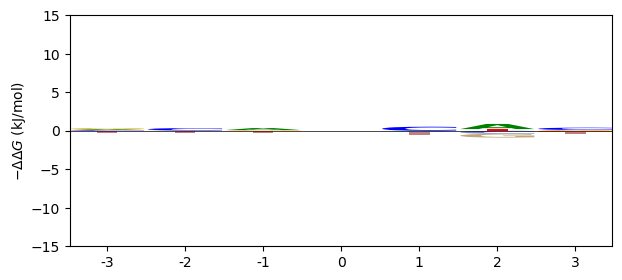

I: It is suggested to extend the core motif at the 5' end by 0 and at the 3' end by 0 positions.


In [18]:
### Based on the motif of CORE_MOTIF_LENGTH analyze the neigbouring positions 
### whether their inclusion can improve the quality of the motif
df_positions=model_best_repetition.investigate_extension_parallel(X_train,y_train, end5=3, end3=3, nuc_type=NUC_TYPE)

list_positions=df_positions.index[df_positions['+2%']].tolist()+[0] # list of positions with an increase of2% and default position 0
ext5=-min(list_positions)
ext3=max(list_positions)
print("I: It is suggested to extend the core motif at the 5' end by %i and at the 3' end by %i positions." %(ext5, ext3))

In [19]:
### fit & predict optimization starting with extended energy matrix if extension appears to improve prediction

if ext5+ext3!=0: #extension suggestion from previous analysis of the bordering positions
    expanded_energies=model_best_repetition.energies_
    # append energies of single-optimized bordering positions to energies of central part
    if ext5!=0:
        energies_5=np.concatenate(df_positions['energies'][(df_positions.index<0) & (df_positions.index>=-ext5)].to_numpy())
        expanded_energies=np.concatenate((energies_5, expanded_energies))
    if ext3!=0:
        energies_3=np.concatenate(df_positions['energies'][(df_positions.index<=ext3) & (df_positions.index>0)].to_numpy().flatten())
        expanded_energies=np.concatenate((expanded_energies,  energies_3))

    mf.energies2logo(expanded_energies, nuc_type=NUC_TYPE)
    print('I: Optimization started with following extended motif.')
    expanded_motif_length=len(expanded_energies)//4
    
    
    model_extended=mf.findmotif(motif_length=expanded_motif_length, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                   start=expanded_energies, fit_G0=True)

    start = time()
    model_extended.fit(X_train,y_train)
    print("Optimization took %.2f hours." % ((time() - start)/3600))

    # print & display main results
    model_extended.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

    # store results and display stages
    STAGES.append('train, extended', model_extended, new_entries={'r (test)': mf.linregress(model_extended.predict(X_test),y_test).rvalue})
    mf.display_df(STAGES.df, nuc_type=NUC_TYPE)
else:
    print('I: Motif is not extended based on previous analysis.')

I: Motif is not extended based on previous analysis.


I: At least one of the bordering positions of the current motif has an information content of at least 0.25. Extending.


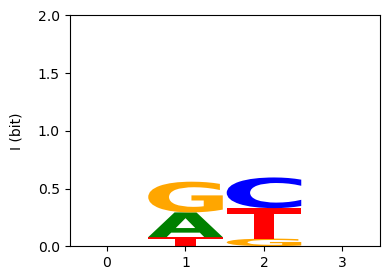

In [ ]:
### fit & predict optimization starting with extended energy matrix plus one bordering position on each side if current bordering position exceed the information of 0.25

last_model=STAGES.df.at[max(STAGES.df.index),'model']
I_5=mf.energies2information(last_model.energies_[0:4])>=0.25 #sufficient information content of 5' end position
I_3=mf.energies2information(last_model.energies_[-4:])>=0.25 #sufficient information content of 3' end position

if I_5 or I_3:
    print('I: At least one of the bordering positions of the current motif has an information content of at least 0.25. Extending.')
    expanded_energies_with_border=mf.modify_energies(last_model.energies_, end5=I_5, end3=I_3)  
    mf.energies2logo(expanded_energies_with_border, nuc_type=NUC_TYPE)
    motif_length_with_border=len(expanded_energies_with_border)//4

    model_with_border=mf.findmotif(motif_length=motif_length_with_border, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                   start=expanded_energies_with_border, fit_G0=True)


    start = time()
    model_with_border.fit(X_train,y_train)
    print("Optimization took %.2f hours." % ((time() - start)/3600))

    # print & display main results
    model_with_border.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

    # store results and display stages
    STAGES.append('train, expanded, border', model_with_border, new_entries={'r (test)': mf.linregress(model_with_border.predict(X_test),y_test).rvalue})
    mf.display_df(STAGES.df, nuc_type=NUC_TYPE)
else:
    print('I: Both bordering positions of the found motif have an information content below 0.25. No futher optimization required.')

In [ ]:
last_model=STAGES.df.at[max(STAGES.df.index),'model']
df_relevant_positions=last_model.explore_positions(X_train, y_train)
list_positions=df_relevant_positions.index[df_relevant_positions['-2%']].tolist() # list of positions with an increase of2% and default position 0
start_relevant=min(list_positions)
end_relevant=max(list_positions)
red5=-start_relevant
red3=end_relevant-len(df_relevant_positions)+1
print('I: The analysis suggests, that positions between %i to %i contribute significantly to the motif' %(start_relevant, end_relevant))
last_model=STAGES.df.at[max(STAGES.df.index),'model']

if (end_relevant-start_relevant+1)in STAGES.df['motif length'].to_list():
    print('I: No need for a further optimization. An optimization with motif length of %i has already been done.' %(end_relevant-start_relevant+1))
    print('I: Checking whether G0 has been chosen correctly.')
    last_model.investigate_G0(X_train, y_train)
else:
    print('I: Bordering positions only marginally contributing towards regression quality are dropped.')
    print('I: New start energy for motif optimization:')
    start_final_model=mf.modify_energies(last_model.energies_, end5=red5, end3=red3)
    mf.energies2logo(start_final_model, nuc_type=NUC_TYPE)
    final_model=mf.findmotif(motif_length=len(start_final_model)//4, protein_conc=PROT_CONC, 
                             both_strands=BOTH_STRANDS, start=start_final_model)

    start = time()
    final_model.fit(X_train,y_train)
    print("Optimization took %.2f hours." % ((time() - start)/3600))

    # print & display main results
    final_model.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)
    
    print('I: Checking whether G0 has been chosen correctly.')
    final_model.investigate_G0(X_train, y_train)

    # store results and display stages
    STAGES.append('train, shrinked', final_model, new_entries={'r (test)': mf.linregress(final_model.predict(X_test),y_test).rvalue})
    mf.display_df(STAGES.df, nuc_type=NUC_TYPE)  

In [ ]:
# refit model to minimize mae
last_model=STAGES.df.at[max(STAGES.df.index),'model']
refitted_model=last_model.refit_mae(X_train,y_train)

# print & display main results
refitted_model.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, mae optimzed', refitted_model, new_entries={'r (test)': mf.linregress(refitted_model.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

# for test
refitted_model.analyse_motif(X_test,y_test, THRESHOLD, nuc_type=NUC_TYPE)

In [ ]:
### allow for dissociation
last_model=STAGES.df.at[max(STAGES.df.index),'model']

# fit & predict optimization starting with previous energy matrix
model_diss=mf.findmotif(motif_length=len(last_model.energies_)//4, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                        start=last_model.energies_,
                        time_dissociation=TIME_DISS,
                        fit_G0=True,
                        max_bind_target=0.1)

start = time()
model_diss.fit(X_train,y_train)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_diss.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, diss.', model_diss, new_entries={'r (test)': mf.linregress(model_diss.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

In [ ]:
### finalize model with complete dataset and allow for dissociation
last_model=STAGES.df.at[max(STAGES.df.index),'model']

# fit & predict optimization starting with previous energy matrix
model_diss=mf.findmotif(motif_length=len(last_model.energies_)//4, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                       start=last_model.energies_,
                       time_dissociation=2*TIME_DISS,
                       fit_G0=True,
                       max_bind_target=0.1)

start = time()
model_diss.fit(X_train,y_train)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_diss.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, 2*diss.', model_diss, new_entries={'r (test)': mf.linregress(model_diss.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

In [ ]:
### finalize model with complete dataset and allow for dissociation
last_model=STAGES.df.at[max(STAGES.df.index),'model']

# fit & predict optimization starting with previous energy matrix
model_diss=mf.findmotif(motif_length=len(last_model.energies_)//4, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                       start=last_model.energies_,
                       time_dissociation=4*TIME_DISS,
                       fit_G0=True,
                       max_bind_target=0.1)

start = time()
model_diss.fit(X_train,y_train)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_diss.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, 4*diss.', model_diss, new_entries={'r (test)': mf.linregress(model_diss.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

In [ ]:
### finalize model with complete dataset and allow for dissociation
last_model=STAGES.df.at[max(STAGES.df.index),'model']

# fit & predict optimization starting with previous energy matrix
model_diss=mf.findmotif(motif_length=len(last_model.energies_)//4, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                       start=last_model.energies_,
                       time_dissociation=8*TIME_DISS,
                       fit_G0=True,
                       max_bind_target=0.1)

start = time()
model_diss.fit(X_train,y_train)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_diss.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, 8*diss.', model_diss, new_entries={'r (test)': mf.linregress(model_diss.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

In [ ]:
STAGES.df.to_json('%s_%s-%s-%s_%s-%s.json' %(PROTEIN_NAME, datetime.now().year, datetime.now().month,datetime.now().day , datetime.now().hour, datetime.now().minute))